# **Tarea 3**
Saul Ivan Rivas Vega

## Importamos las librerias necesarias

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import chain
from itertools import combinations_with_replacement as combinations_w_r
from scipy.sparse.linalg import lsqr

# Implementación de norma l1 LASSO de sickit learn
from sklearn.linear_model import Lasso

# Definimos el seed para el random
np.random.seed(0)

## Definimos funciones globales

#### Definimos la función de expansión de polinomios
Esta función recibe una matriz, cada fila es un vector de atributos de cada muestra, también recibe el grado del polinomio.
La función devuelve una matriz con cada fila con la correspondiente expansion polinomial.
Ejemplo para una matriz de 2 muestras, una con parametros con valor 'a' y 'b', y la otra con los valores 'c' y 'd', con grado igual a 2:

getPoly([[a,b],[c,d]], 2) = [[1,a,b,aa,bb], [1,c,d,cc,dd]]

No toma en cuenta las interacciones.

In [0]:
def getPoly(X, degree):
  phi_X = X
  for i in range(degree - 1):
    powerX = np.power(X, i + 2)
    phi_X = np.column_stack((phi_X, powerX))
    
  ones_column = np.ones(phi_X.shape[0])
  return np.column_stack((ones_column, phi_X))

#### Definimos la estimación del vector $\hat{\theta}_{emv}$ utilizando minimos cuadrados.

In [0]:
def theta_ms(X, y):

  # Obtenemos la solución de minimos cuadrados para esta ecuación lineal
  out = lsqr(X, y)
  theta = out[0]

  # Devolvemos el vector theta
  return theta

#### Definimos la función de evaluación de un modelo lineal es decir multiplicar una matriz de diseño por un vector $\hat{\theta}$.

In [0]:
def linear_model_f(Xp, theta):
  return Xp @ theta

#### Definimos la función de evaluación de un modelo logistico es decir el resultado de evaluar una función sigmoide a una multiplicación de una matriz de diseño por un vector $\hat{\theta}$  y evaluar una función sigmoide.

In [0]:
def logistic_model_f(Xp, theta):
  y_hat = Xp @ theta
  y_hat = np.ones(shape=y_hat.shape) / (np.exp(-y_hat) + 1)
  return y_hat

#### Definimos la función para calcular la suma de errores cuadráticos 

In [0]:
def sum_square_error(y, y_hat):
  return np.square(y - y_hat).sum()

#### Definimos la estimación del vector $\hat{\theta}_{emv}$ utilizando minimos cuadrados con penalización de norma $l_2$.

In [0]:
def theta_ms_l2(X, y, current_lambda):
  lcI = current_lambda * np.identity(X.shape[1])
  theta = np.linalg.inv(lcI + X.T @ X) @ X.T @ y
  return theta

#### Definimos la estimación del vector $\hat{\theta}_{emv}$ utilizando minimos cuadrados con penalización de norma $l_1$ (LASSO).

In [0]:
def theta_ms_l1(X, y, current_lambda):
  model = Lasso(alpha=current_lambda, tol=0.8)
  model.fit(X,y)
  theta = model.coef_
  return theta

### Definimos la función para el cálculo de la curva ROC

In [0]:
def ratio_ft(probabilities, threshold_i):
  return np.mean(probabilities >= threshold_i)


def roc(y_hat, y):
  positive_el = np.where(y == 1)
  negative_el = np.where(y == 0)
  
  unique_probabilities = np.unique(y_hat)
  rtps = np.zeros(unique_probabilities.shape[0])
  rfps = np.zeros_like(rtps)
  
  for i, p in enumerate(unique_probabilities[::-1]):
    rtps[i] = ratio_ft(y_hat[positive_el], p)
    rfps[i] = ratio_ft(y_hat[negative_el], p)

  return rtps, rfps

### Definimos la función que calcula el area bajo la curva ROC y Precisión exhaustividad

In [0]:
def polygon_area(vertices):
    area = 0.0
    n_vert = len(vertices)
    for i in range(n_vert - 1):
        area = area + vertices[i][0] * vertices[i + 1][1]
        area = area - vertices[i + 1][0] * vertices[i][1]

    area = area + vertices[n_vert - 1][0] * vertices[0][1]
    area = area - vertices[0][0] * vertices[n_vert - 1][1]

    return 0.5 * abs(area)

def aucrocprecex(rfp, rtp, initial_y):
  auc = 0.0
  fprev = 0.0
  vprev = initial_y
  for i,(f,v) in enumerate(zip(rfp, rtp)):
    auc += polygon_area([[fprev, 0], [fprev, vprev], [f, v], [f, 0]])
    fprev = f
    vprev = v

  return auc + polygon_area([[fprev, 0], [fprev, vprev], [1, 1], [1, 0]])

### Definimos la función para el cálculo de la curva Precisión Exhaustividad

In [0]:
def prec_exha(y_hat, y):
  positive_el = np.where(y == 1)
  
  unique_probabilities = np.unique(y_hat)
  exha_val = np.zeros(unique_probabilities.shape[0])
  prec_val = np.zeros_like(exha_val)
  
  for i, p in enumerate(unique_probabilities[::-1]):
    exha_val[i] = ratio_ft(y_hat[positive_el], p)
    true_positives = y_hat[positive_el] >= p
    selected_items = y_hat >= p
    prec_val[i] =  np.sum(true_positives) / np.sum(selected_items)

    

  return exha_val, prec_val

## Ejercicio 1 - Predicción de precios de casas

A partir de la base de datos de precios de casas de Boston (Boston Housing Data), realiza la regresión de los precios de las casas con las siguientes variantes:
1. Mínimos cuadrados con expansión polinomial de diferentes grados.
2. Mínimos cuadrados con expansión polinomial de grado 20 y penalización por norma $\mathcal{l}_1$ y $\mathcal{l}_2$ con diferentes valores de λ.
3. Mínimos cuadrados con expansión polinomial de grado 2 y selección de atributos.

Grafica el error cuadrático medio en entrenamiento y validación con respecto al grado del polinomio, valor de λ y número de atributos.
Todos los modelos deberán ser evaluados con 10 repeticiones de
validación cruzada de 5 particiones.

### Obtenemos la base de datos

In [0]:
!wget -O housing.data http://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data

--2020-04-17 08:26:22--  http://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49082 (48K) [application/x-httpd-php]
Saving to: ‘housing.data’

housing.data        100%[===================>]  47.93K  --.-KB/s    in 0.1s    

2020-04-17 08:26:22 (346 KB/s) - ‘housing.data’ saved [49082/49082]



#### Obtenemos la descripción de los atributos


In [0]:
!wget -O housing.names http://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.names

--2020-04-17 08:26:22--  http://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.names
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2080 (2.0K) [application/x-httpd-php]
Saving to: ‘housing.names’

housing.names       100%[===================>]   2.03K  --.-KB/s    in 0.003s  

2020-04-17 08:26:22 (591 KB/s) - ‘housing.names’ saved [2080/2080]



#### Visualizamos la descripción de los atributos



In [0]:
f = open('housing.names', 'r')
file_contents = f.read()
print(file_contents)

1. Title: Boston Housing Data

2. Sources:
   (a) Origin:  This dataset was taken from the StatLib library which is
                maintained at Carnegie Mellon University.
   (b) Creator:  Harrison, D. and Rubinfeld, D.L. 'Hedonic prices and the 
                 demand for clean air', J. Environ. Economics & Management,
                 vol.5, 81-102, 1978.
   (c) Date: July 7, 1993

3. Past Usage:
   -   Used in Belsley, Kuh & Welsch, 'Regression diagnostics ...', Wiley, 
       1980.   N.B. Various transformations are used in the table on
       pages 244-261.
    -  Quinlan,R. (1993). Combining Instance-Based and Model-Based Learning.
       In Proceedings on the Tenth International Conference of Machine 
       Learning, 236-243, University of Massachusetts, Amherst. Morgan
       Kaufmann.

4. Relevant Information:

   Concerns housing values in suburbs of Boston.

5. Number of Instances: 506

6. Number of Attributes: 13 continuous attributes (including "class"
                

#### Visualizamos la base de datos incorporando la fila de los atributos

In [0]:
atribute_header = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
housing_data = pd.read_csv('housing.data', header=None, delim_whitespace=True)
housing_data.columns = atribute_header
housing_data

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,393.45,6.48,22.0


### Parte 1:  Mínimos cuadrados con expansión polinomial de diferentes grados.

En este caso probaremos los siguientes grados: [1, 2, 4, 8, 16].

Y como cuenta con 13 parametros tomaremos variando los atributos seleccionados, tomando solo el primer atributo, los primeros 4, los primeros 8 y finalmente con todos los atributos.


#### Visualicemos el caso en donde solo tomamos en cuenta al primer atributo, el cual es la taza de crimen.

##### Solo obtenemos las muestras con los atributos a utilizar, la taza de crimen (CRIM) para X, y el valor medio (MEDV) para Y

In [0]:
crime_value_house_data = housing_data[['CRIM','MEDV']].copy()
crime_value_house_data

,CRIM,MEDV
0,0.00632,24.0
1,0.02731,21.6
2,0.02729,34.7
3,0.03237,33.4
4,0.06905,36.2
...,...,...
501,0.06263,22.4
502,0.04527,20.6
503,0.06076,23.9
504,0.10959,22.0


##### Visualicemos solo un ejemplo.
Para saber que se hará en todas las iteraciones.

Probemos un ejemplo con grado 3 y usando solo una partición de las k particiones.


In [0]:
# Definimos el degree y el k para el ejemplo, en este caso k = 5 y se considera que las particiones tendrán 101 elementos con excepción de 1 que tendrá 102
example_degree = 3
example_k = 5

# Obtenemos una permutación aleatoria de todo el conjunto de datos
example_shuffled_crime_value_house_data = crime_value_house_data.iloc[np.random.permutation(range(crime_value_house_data.shape[0]))].copy()

# Obtenemos las k particiones
example_split_shuffled_crime_value_house_data = np.array_split(example_shuffled_crime_value_house_data, example_k)

# Solo usamos la primera parte como test y lo demas como entrenamiento para este ejemplo
example_crime_value_house_data_test = example_split_shuffled_crime_value_house_data[0]
example_crime_value_house_data_train = example_shuffled_crime_value_house_data.loc[~example_shuffled_crime_value_house_data.index.isin(example_crime_value_house_data_test.index)]

# Obtenemos nuestra matriz de atributos, aunque cada vector de atributos en este caso solo tiene un elemento, la taza de crimen
example_train_feature_matrix = np.array(np.split(np.array(example_crime_value_house_data_train['CRIM'].copy().values),example_crime_value_house_data_train.shape[0]))

# Obtenemos la matriz de diseño que obteniendo la expansion del polinomio
example_train_design_matrix_X = getPoly(example_train_feature_matrix, example_degree)

# Obtenemos nuestro vector de Theta por minimos cuadrados
example_theta_hat = theta_ms(example_train_design_matrix_X, np.array(example_crime_value_house_data_train['MEDV'].copy().values))
print(example_theta_hat)


[ 2.55051971e+01 -1.32607890e+00  2.96883079e-02 -1.91622968e-04]


Probemos ahora grafical el modelo entrenado junto con los datos de validación y entrenamiento.

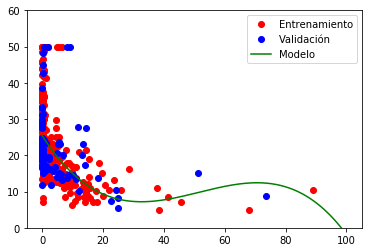

In [0]:
# Obtenemos el rango a graficar
example_X_rango = np.array(np.split(np.linspace(0, 100, 10000), 10000))

# Obtenemos su matriz de diseño
example_X_rango_design_matrix = getPoly(example_X_rango, example_degree)

# Obtenemos las predicciones del rango
example_y_hat_rango = linear_model_f(example_X_rango_design_matrix, example_theta_hat)

# Graficamos

# Agregamos la grafica para los valores de entrenamiento
train_plot = plt.plot(example_crime_value_house_data_train['CRIM'], example_crime_value_house_data_train['MEDV'], 'ro', label = 'Entrenamiento')

# Agregamos la grafica para los valores de validación
valid_plot = plt.plot(example_crime_value_house_data_test['CRIM'], example_crime_value_house_data_test['MEDV'], 'bo', label = u'Validación')

# Agregamos los valores del rango
plt.plot(np.linspace(0, 100, 10000), example_y_hat_rango, 'g', label='Modelo')

# Limitamos la grafica para no perder la relación entre los puntos
plt.ylim([0, 60])

# Mostramos
plt.legend()
plt.show()

Finalmente hagamos la predicción para los conjuntos de entrenamiento y obtengamos la suma de errores cuadraticos y el error cuadrático medio:

In [0]:
# Predicciones

# Conjunto de Entrenamiento
# Obtenemos nuestra matriz de atributos, aunque cada vector de atributos en este caso solo tiene un elemento, la taza de crimen
example_train_feature_matrix = np.array(np.split(np.array(example_crime_value_house_data_train['CRIM'].copy().values),example_crime_value_house_data_train.shape[0]))

# Obtenemos la matriz de diseño que obteniendo la expansion del polinomio
example_train_design_matrix_X = getPoly(example_train_feature_matrix, example_degree)

# Obtenemos la predicción
example_y_hat_train = linear_model_f(example_train_design_matrix_X, example_theta_hat)

# Conjunto de Validación
# Obtenemos nuestra matriz de atributos, aunque cada vector de atributos en este caso solo tiene un elemento, la taza de crimen
example_test_feature_matrix = np.array(np.split(np.array(example_crime_value_house_data_test['CRIM'].copy().values),example_crime_value_house_data_test.shape[0]))

# Obtenemos la matriz de diseño que obteniendo la expansion del polinomio
example_test_design_matrix_X = getPoly(example_test_feature_matrix, example_degree)

# Obtenemos la predicción
example_y_hat_test = linear_model_f(example_test_design_matrix_X, example_theta_hat)

# Suma de errores
# La suma de errores cuadraticos para entrenamiento y validación
example_sse_train = sum_square_error(example_crime_value_house_data_train['MEDV'], example_y_hat_train)
example_sse_test = sum_square_error(example_crime_value_house_data_test['MEDV'], example_y_hat_test)

# El error cuadrático medio para entrenamiento y validación
example_mse_train = example_sse_train / example_crime_value_house_data_train.shape[0]
example_mse_test = example_sse_test / example_crime_value_house_data_test.shape[0]

print('SSE (Train) = {0}, SSE (Test) = {1}'.format(example_sse_train, example_sse_test))
print('MSE (Train) = {0}, MSE (Test) = {1}'.format(example_mse_train, example_mse_test))

SSE (Train) = 25633.68677691926, SSE (Test) = 7930.808757682792
MSE (Train) = 63.44971974484966, MSE (Test) = 77.7530270361058


#### Desarrollo de la parte 1
Tomamos en cuenta los grados [1, 2, 4, 8, 16] y tomando solo el primer atributo, los primeros 4, los primeros 8 y finalmente con todos los atributos.


In [0]:
# Los primeros atributos a probar
p1_attr = [1, 4, 8, 13]

# Los grados del polinomio a probar
p1_degrees = [1, 2, 4, 8, 16]

# Numero de repeticiones
p1_repetitions = 10

# Numero de particiones
p1_k_folds = 5

# Inicializamos las listas donde almacenaremos los resultados
housing_p1_mse_per_attributes_train = []
housing_p1_mse_per_attributes_test = []

# Recorremos el arreglo que determina los primeros n atributos que se toman en cuenta
for first_attributes in p1_attr:

  # Inicializamos las listas donde almacenaremos los resultados por grado del polinomio
  housing_p1_mse_per_degree_train = np.array([])
  housing_p1_mse_per_degree_test = np.array([])

  # Recorremos los distintos grados del polinomio 
  for p_degree in p1_degrees:
    
    # Inicializamos las listas donde almacenaremos los resultados por repetición
    housing_p1_mse_per_repetition_train = np.array([])
    housing_p1_mse_per_repetition_test = np.array([])

    # Para la validación cruzada probaremos con 10 repeticiones
    for repetition_i in range(p1_repetitions):
      # Obtenemos las particiones haciendo un random shuffle del data set y dividiendolo en k particiones
      shuffled_housing_data = housing_data.iloc[np.random.permutation(range(housing_data.shape[0]))].copy()
      split_shuffled_housing_data = np.array_split(shuffled_housing_data, p1_k_folds)

      # Inicializamos las listas donde almacenaremos los resultados por partición
      housing_p1_mse_per_fold_train = np.array([])
      housing_p1_mse_per_fold_test = np.array([])
      
      # Y por repeticion probaremos usar cada una de las particiones como test y las demas como entrenamiento.
      for test_partition in range(p1_k_folds):
        
        # Definimos el conjunto de validación y de entrenamiento
        house_data_test = split_shuffled_housing_data[test_partition]
        house_data_train = shuffled_housing_data.loc[~shuffled_housing_data.index.isin(house_data_test.index)]
        
        # Obtenemos nuestra matriz de atributos dependiendo de cuales son los primeros atributos
        feature_matrix_train = np.array(house_data_train[atribute_header[:first_attributes]].copy().values)
        
        # Obtenemos la matriz de diseño que obteniendo la expansion del polinomio
        design_matrix_X_train = getPoly(feature_matrix_train, p_degree)
        
        # Obtenemos nuestro vector de Theta por minimos cuadrados
        theta_hat = theta_ms(design_matrix_X_train, np.array(house_data_train['MEDV'].copy().values))

        # Obtenemos la predicción para entrenamiento
        y_hat_train = linear_model_f(design_matrix_X_train, theta_hat)

        # Conjunto de Validación
        # Obtenemos nuestra matriz de atributos
        feature_matrix_test = np.array(house_data_test[atribute_header[:first_attributes]].copy().values)

        # Obtenemos la matriz de diseño que obteniendo la expansion del polinomio
        design_matrix_X_test = getPoly(feature_matrix_test, p_degree)

        # Obtenemos la predicción
        y_hat_test = linear_model_f(design_matrix_X_test, theta_hat)

        # Suma de errores
        # La suma de errores cuadraticos para entrenamiento y validación
        sse_train = sum_square_error(house_data_train['MEDV'], y_hat_train)
        sse_test = sum_square_error(house_data_test['MEDV'], y_hat_test)

        # El error cuadrático medio para entrenamiento y validación
        mse_train = sse_train / house_data_train.shape[0]
        mse_test = sse_test / house_data_test.shape[0]

        # print('First attributes = {0}, Degree = {1}, Repetition = {2}, Fold = {3}, MSE (Train) = {4}, MSE (Test) = {5}'.format(first_attributes, p_degree, repetition_i, test_partition, mse_train, mse_test))

        # Agregamos a las listas de resultados por partición
        housing_p1_mse_per_fold_train = np.append(housing_p1_mse_per_fold_train, mse_train)
        housing_p1_mse_per_fold_test = np.append(housing_p1_mse_per_fold_test, mse_test)

      # Habiendo terminado las k particiones obtenemos los promedios y los agregamos a las listas de resultados por repeteción
      print('First attributes = {0}, Degree = {1}, Repetition = {2}, len_MSE (Train) = {3}, len_MSE (Test) = {4}'.format(first_attributes, p_degree, repetition_i, housing_p1_mse_per_fold_train.shape, housing_p1_mse_per_fold_test.shape))
      housing_p1_mse_per_repetition_train = np.append(housing_p1_mse_per_repetition_train, housing_p1_mse_per_fold_train.mean())
      housing_p1_mse_per_repetition_test = np.append(housing_p1_mse_per_repetition_test, housing_p1_mse_per_fold_test.mean())
    
    # Habiendo terminado las n repeticiones obtenemos los promedios y los agregamos a las listas de resultados por grado del polinomio
    housing_p1_mse_per_degree_train = np.append(housing_p1_mse_per_degree_train, housing_p1_mse_per_repetition_train.mean())
    housing_p1_mse_per_degree_test = np.append(housing_p1_mse_per_degree_test, housing_p1_mse_per_repetition_test.mean())

  # Habiendo terminado de recorrer los grados los agregamos a las listas de resultados por numero de atributos
  housing_p1_mse_per_attributes_train.append(housing_p1_mse_per_degree_train)
  housing_p1_mse_per_attributes_test.append(housing_p1_mse_per_degree_test)

First attributes = 1, Degree = 1, Repetition = 0, len_MSE (Train) = (5,), len_MSE (Test) = (5,)
First attributes = 1, Degree = 1, Repetition = 1, len_MSE (Train) = (5,), len_MSE (Test) = (5,)
First attributes = 1, Degree = 1, Repetition = 2, len_MSE (Train) = (5,), len_MSE (Test) = (5,)
First attributes = 1, Degree = 1, Repetition = 3, len_MSE (Train) = (5,), len_MSE (Test) = (5,)
First attributes = 1, Degree = 1, Repetition = 4, len_MSE (Train) = (5,), len_MSE (Test) = (5,)
First attributes = 1, Degree = 1, Repetition = 5, len_MSE (Train) = (5,), len_MSE (Test) = (5,)
First attributes = 1, Degree = 1, Repetition = 6, len_MSE (Train) = (5,), len_MSE (Test) = (5,)
First attributes = 1, Degree = 1, Repetition = 7, len_MSE (Train) = (5,), len_MSE (Test) = (5,)
First attributes = 1, Degree = 1, Repetition = 8, len_MSE (Train) = (5,), len_MSE (Test) = (5,)
First attributes = 1, Degree = 1, Repetition = 9, len_MSE (Train) = (5,), len_MSE (Test) = (5,)
First attributes = 1, Degree = 2, Repeti

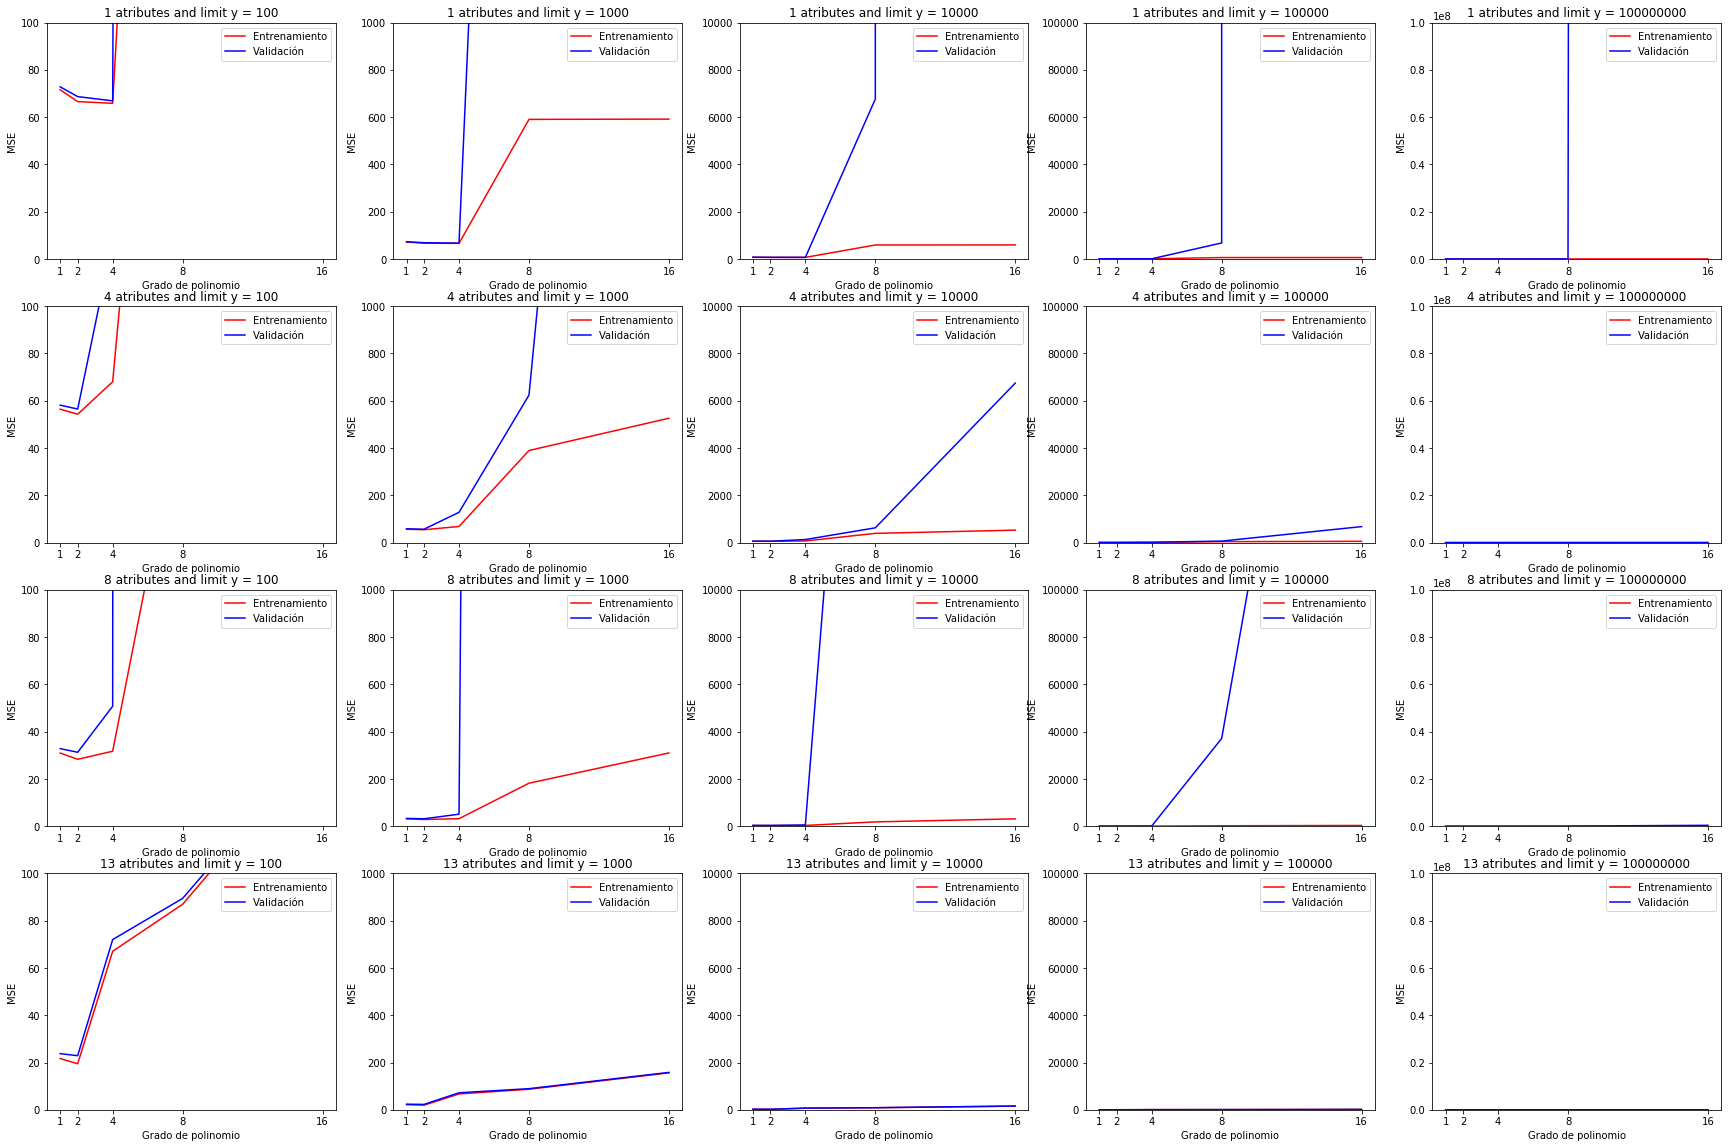

In [0]:
# Graficamos los errores medios
# Distintas escalas 
scales = [100, 1000, 10000, 100000, 100000000]
fig, ax = plt.subplots(nrows=len(p1_attr), ncols=len(scales), figsize=(30,20))
for i in range(len(p1_attr)):
  for j in range(len(scales)):
    ax[i, j].plot(p1_degrees, housing_p1_mse_per_attributes_train[i], 'r', label='Entrenamiento')
    ax[i, j].plot(p1_degrees, housing_p1_mse_per_attributes_test[i], 'b', label='Validación')
    ax[i, j].set_xlabel('Grado de polinomio')
    ax[i, j].set_ylabel('MSE')
    ax[i, j].set_ylim([0, scales[j]])
    ax[i, j].set_xticks(ticks=p1_degrees)
    ax[i, j].legend()
    title = '{0} atributes and limit y = {1}'.format(p1_attr[i], scales[j])
    ax[i, j].set_title(title)


Pudimos observar entonces que el error cuadrático medio se varia los conjuntos de entrenamiento y en los de validación, aunque no tanto en los conjuntos de entrenamiento, sin embargo el error aumenta para ambos al aumentar el grado, esto se debe a que mientras aumentamos el grado, caemos en el sobreajuste. Parece ser que la menor cantidad de errores se presentan con polinomios de menor grado, como 2.

### Parte 2: Mínimos cuadrados con expansión polinomial de grado 20 y penalización por norma $\mathcal{l}_1$ y $\mathcal{l}_2$ con diferentes valores de λ.

#### Probaremos con el atributo de la taza de crimen, norma $l_2$ con distintos valores de $\lambda$.

In [0]:
# Las lambdas a probar
p2_nlambda = 9
p2_lambda = np.geomspace(1e-20, 1e20, num=p2_nlambda)

# Los primeros atributos a probar
p2_attr = [1]

# Los grados del polinomio a probar
p2_degrees = [20]

# Numero de repeticiones
p2_repetitions = 10

# Numero de particiones
p2_k_folds = 5

# Inicializamos las listas donde almacenaremos los resultados por lambda
housing_p2_mse_per_lambda_train = []
housing_p2_mse_per_lambda_test = []

for current_lambda_i in range(p2_nlambda):

  # Inicializamos las listas donde almacenaremos los resultados por atributos utilizados
  housing_p2_mse_per_attributes_train = []
  housing_p2_mse_per_attributes_test = []

  # Recorremos el arreglo que determina los primeros n atributos que se toman en cuenta
  for first_attributes in p2_attr:

    # Inicializamos las listas donde almacenaremos los resultados por grado del polinomio
    housing_p2_mse_per_degree_train = np.array([])
    housing_p2_mse_per_degree_test = np.array([])

    # Recorremos los distintos grados del polinomio 
    for p_degree in p2_degrees:
      
      # Inicializamos las listas donde almacenaremos los resultados por repetición
      housing_p2_mse_per_repetition_train = np.array([])
      housing_p2_mse_per_repetition_test = np.array([])

      # Para la validación cruzada probaremos con 10 repeticiones
      for repetition_i in range(p2_repetitions):
        # Obtenemos las particiones haciendo un random shuffle del data set y dividiendolo en k particiones
        shuffled_housing_data = housing_data.iloc[np.random.permutation(range(housing_data.shape[0]))].copy()
        split_shuffled_housing_data = np.array_split(shuffled_housing_data, p2_k_folds)

        # Inicializamos las listas donde almacenaremos los resultados por partición
        housing_p2_mse_per_fold_train = np.array([])
        housing_p2_mse_per_fold_test = np.array([])
        
        # Y por repeticion probaremos usar cada una de las particiones como test y las demas como entrenamiento.
        for test_partition in range(p2_k_folds):
          
          # Definimos el conjunto de validación y de entrenamiento
          house_data_test = split_shuffled_housing_data[test_partition]
          house_data_train = shuffled_housing_data.loc[~shuffled_housing_data.index.isin(house_data_test.index)]
          
          # Obtenemos nuestra matriz de atributos dependiendo de cuales son los primeros atributos
          feature_matrix_train = np.array(house_data_train[atribute_header[:first_attributes]].copy().values)
          
          # Obtenemos la matriz de diseño que obteniendo la expansion del polinomio
          design_matrix_X_train = getPoly(feature_matrix_train, p_degree)
          
          # Obtenemos nuestro vector de Theta por minimos cuadrados con norma L2
          theta_hat = theta_ms_l2(design_matrix_X_train, np.array(house_data_train['MEDV'].copy().values), p2_lambda[current_lambda_i])

          # Obtenemos la predicción para entrenamiento
          y_hat_train = linear_model_f(design_matrix_X_train, theta_hat)

          # Conjunto de Validación
          # Obtenemos nuestra matriz de atributos
          feature_matrix_test = np.array(house_data_test[atribute_header[:first_attributes]].copy().values)

          # Obtenemos la matriz de diseño que obteniendo la expansion del polinomio
          design_matrix_X_test = getPoly(feature_matrix_test, p_degree)

          # Obtenemos la predicción
          y_hat_test = linear_model_f(design_matrix_X_test, theta_hat)

          # Suma de errores
          # La suma de errores cuadraticos para entrenamiento y validación
          sse_train = sum_square_error(house_data_train['MEDV'], y_hat_train)
          sse_test = sum_square_error(house_data_test['MEDV'], y_hat_test)

          # El error cuadrático medio para entrenamiento y validación
          mse_train = sse_train / house_data_train.shape[0]
          mse_test = sse_test / house_data_test.shape[0]

          # print('First attributes = {0}, Degree = {1}, Repetition = {2}, Fold = {3}, MSE (Train) = {4}, MSE (Test) = {5}'.format(first_attributes, p_degree, repetition_i, test_partition, mse_train, mse_test))

          # Agregamos a las listas de resultados por partición
          housing_p2_mse_per_fold_train = np.append(housing_p2_mse_per_fold_train, mse_train)
          housing_p2_mse_per_fold_test = np.append(housing_p2_mse_per_fold_test, mse_test)

        # Habiendo terminado las k particiones obtenemos los promedios y los agregamos a las listas de resultados por repeteción
        print('lambda_i = {0}, First attributes = {1}, Degree = {2}, Repetition = {3}, len_MSE (Train) = {4}, len_MSE (Test) = {5}'.format(current_lambda_i, first_attributes, p_degree, repetition_i, housing_p2_mse_per_fold_train.shape, housing_p2_mse_per_fold_test.shape))
        housing_p2_mse_per_repetition_train = np.append(housing_p2_mse_per_repetition_train, housing_p2_mse_per_fold_train.mean())
        housing_p2_mse_per_repetition_test = np.append(housing_p2_mse_per_repetition_test, housing_p2_mse_per_fold_test.mean())
      
      # Habiendo terminado las n repeticiones obtenemos los promedios y los agregamos a las listas de resultados por grado del polinomio
      housing_p2_mse_per_degree_train = np.append(housing_p2_mse_per_degree_train, housing_p2_mse_per_repetition_train.mean())
      housing_p2_mse_per_degree_test = np.append(housing_p2_mse_per_degree_test, housing_p2_mse_per_repetition_test.mean())

    # Habiendo terminado de recorrer los grados los agregamos a las listas de resultados por numero de atributos
    housing_p2_mse_per_attributes_train.append(housing_p2_mse_per_degree_train[0])
    housing_p2_mse_per_attributes_test.append(housing_p2_mse_per_degree_test[0])

  # Habiendo terminado de recorrer los atributos los agregamos a las listas de resultados por lambda
  housing_p2_mse_per_lambda_train.append(housing_p2_mse_per_attributes_train[0])
  housing_p2_mse_per_lambda_test.append(housing_p2_mse_per_attributes_test[0])

lambda_i = 0, First attributes = 1, Degree = 20, Repetition = 0, len_MSE (Train) = (5,), len_MSE (Test) = (5,)
lambda_i = 0, First attributes = 1, Degree = 20, Repetition = 1, len_MSE (Train) = (5,), len_MSE (Test) = (5,)
lambda_i = 0, First attributes = 1, Degree = 20, Repetition = 2, len_MSE (Train) = (5,), len_MSE (Test) = (5,)
lambda_i = 0, First attributes = 1, Degree = 20, Repetition = 3, len_MSE (Train) = (5,), len_MSE (Test) = (5,)
lambda_i = 0, First attributes = 1, Degree = 20, Repetition = 4, len_MSE (Train) = (5,), len_MSE (Test) = (5,)
lambda_i = 0, First attributes = 1, Degree = 20, Repetition = 5, len_MSE (Train) = (5,), len_MSE (Test) = (5,)
lambda_i = 0, First attributes = 1, Degree = 20, Repetition = 6, len_MSE (Train) = (5,), len_MSE (Test) = (5,)
lambda_i = 0, First attributes = 1, Degree = 20, Repetition = 7, len_MSE (Train) = (5,), len_MSE (Test) = (5,)
lambda_i = 0, First attributes = 1, Degree = 20, Repetition = 8, len_MSE (Train) = (5,), len_MSE (Test) = (5,)
l

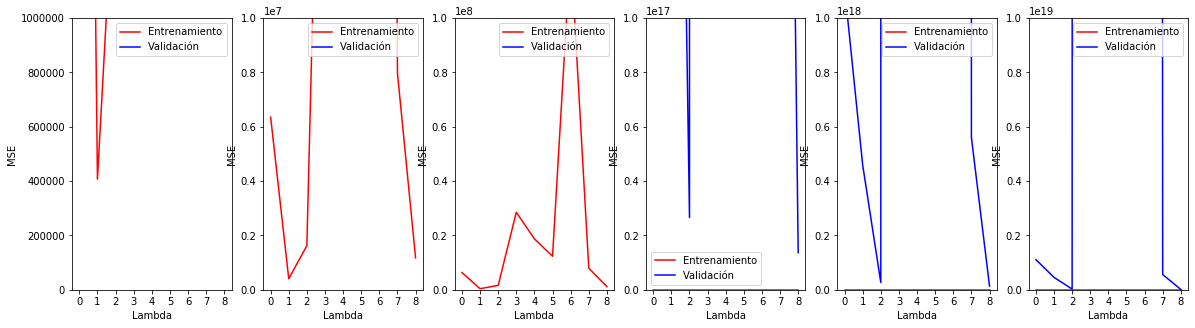

In [0]:
# Graficamos los errores medios
# Distintas escalas 
scales = [1000000, 10000000, 100000000, 100000000000000000, 1000000000000000000, 10000000000000000000]
fig, ax = plt.subplots(nrows=1, ncols=len(scales), figsize=(20,5))
for j in range(len(scales)):
  ax[j].plot(range(p2_nlambda), housing_p2_mse_per_lambda_train, 'r', label='Entrenamiento')
  ax[j].plot(range(p2_nlambda), housing_p2_mse_per_lambda_test, 'b', label='Validación')
  ax[j].set_xlabel('Lambda')
  ax[j].set_ylabel('MSE')
  ax[j].set_ylim([0, scales[j]])
  ax[j].set_xticks(ticks=range(p2_nlambda))
  ax[j].legend()


En general se observa que el error medio se dispara al considerar un polinomio con un grado tal como 20, especialmente para los conjuntos de validación que requieren una escala mucho mayor para poder observarse, parece ser que lambdas cercanas a $10^5$ son las que tienen mejor desempeño, que sigue siendo bastante malo.

#### Probaremos la norma $l_1$ con LASSO

In [0]:
# Las lambdas a probar
p2_2_nlambda = 9
p2_2_lambda = np.geomspace(1e-20, 1e20, num=p2_nlambda)

# Los primeros atributos a probar
p2_2_attr = [1]

# Los grados del polinomio a probar
p2_2_degrees = [20]

# Numero de repeticiones
p2_2_repetitions = 10

# Numero de particiones
p2_2_k_folds = 5

# Inicializamos las listas donde almacenaremos los resultados por lambda
housing_p2_2_mse_per_lambda_train = []
housing_p2_2_mse_per_lambda_test = []

for current_lambda_i in range(p2_2_nlambda):

  # Inicializamos las listas donde almacenaremos los resultados por atributos utilizados
  housing_p2_2_mse_per_attributes_train = []
  housing_p2_2_mse_per_attributes_test = []

  # Recorremos el arreglo que determina los primeros n atributos que se toman en cuenta
  for first_attributes in p2_2_attr:

    # Inicializamos las listas donde almacenaremos los resultados por grado del polinomio
    housing_p2_2_mse_per_degree_train = np.array([])
    housing_p2_2_mse_per_degree_test = np.array([])

    # Recorremos los distintos grados del polinomio 
    for p_degree in p2_2_degrees:
      
      # Inicializamos las listas donde almacenaremos los resultados por repetición
      housing_p2_2_mse_per_repetition_train = np.array([])
      housing_p2_2_mse_per_repetition_test = np.array([])

      # Para la validación cruzada probaremos con 10 repeticiones
      for repetition_i in range(p2_2_repetitions):
        # Obtenemos las particiones haciendo un random shuffle del data set y dividiendolo en k particiones
        shuffled_housing_data = housing_data.iloc[np.random.permutation(range(housing_data.shape[0]))].copy()
        split_shuffled_housing_data = np.array_split(shuffled_housing_data, p2_2_k_folds)

        # Inicializamos las listas donde almacenaremos los resultados por partición
        housing_p2_2_mse_per_fold_train = np.array([])
        housing_p2_2_mse_per_fold_test = np.array([])
        
        # Y por repeticion probaremos usar cada una de las particiones como test y las demas como entrenamiento.
        for test_partition in range(p2_2_k_folds):
          
          # Definimos el conjunto de validación y de entrenamiento
          house_data_test = split_shuffled_housing_data[test_partition]
          house_data_train = shuffled_housing_data.loc[~shuffled_housing_data.index.isin(house_data_test.index)]
          
          # Obtenemos nuestra matriz de atributos dependiendo de cuales son los primeros atributos
          feature_matrix_train = np.array(house_data_train[atribute_header[:first_attributes]].copy().values)
          
          # Obtenemos la matriz de diseño que obteniendo la expansion del polinomio
          design_matrix_X_train = getPoly(feature_matrix_train, p_degree)
          
          # Obtenemos nuestro vector de Theta por minimos cuadrados con norma L2
          theta_hat = theta_ms_l1(design_matrix_X_train, np.array(house_data_train['MEDV'].copy().values), p2_lambda[current_lambda_i])

          # Obtenemos la predicción para entrenamiento
          y_hat_train = linear_model_f(design_matrix_X_train, theta_hat)

          # Conjunto de Validación
          # Obtenemos nuestra matriz de atributos
          feature_matrix_test = np.array(house_data_test[atribute_header[:first_attributes]].copy().values)

          # Obtenemos la matriz de diseño que obteniendo la expansion del polinomio
          design_matrix_X_test = getPoly(feature_matrix_test, p_degree)

          # Obtenemos la predicción
          y_hat_test = linear_model_f(design_matrix_X_test, theta_hat)

          # Suma de errores
          # La suma de errores cuadraticos para entrenamiento y validación
          sse_train = sum_square_error(house_data_train['MEDV'], y_hat_train)
          sse_test = sum_square_error(house_data_test['MEDV'], y_hat_test)

          # El error cuadrático medio para entrenamiento y validación
          mse_train = sse_train / house_data_train.shape[0]
          mse_test = sse_test / house_data_test.shape[0]

          # print('First attributes = {0}, Degree = {1}, Repetition = {2}, Fold = {3}, MSE (Train) = {4}, MSE (Test) = {5}'.format(first_attributes, p_degree, repetition_i, test_partition, mse_train, mse_test))

          # Agregamos a las listas de resultados por partición
          housing_p2_2_mse_per_fold_train = np.append(housing_p2_2_mse_per_fold_train, mse_train)
          housing_p2_2_mse_per_fold_test = np.append(housing_p2_2_mse_per_fold_test, mse_test)

        # Habiendo terminado las k particiones obtenemos los promedios y los agregamos a las listas de resultados por repeteción
        print('lambda_i = {0}, First attributes = {1}, Degree = {2}, Repetition = {3}, len_MSE (Train) = {4}, len_MSE (Test) = {5}'.format(current_lambda_i, first_attributes, p_degree, repetition_i, housing_p2_2_mse_per_fold_train.shape, housing_p2_2_mse_per_fold_test.shape))
        housing_p2_2_mse_per_repetition_train = np.append(housing_p2_2_mse_per_repetition_train, housing_p2_2_mse_per_fold_train.mean())
        housing_p2_2_mse_per_repetition_test = np.append(housing_p2_2_mse_per_repetition_test, housing_p2_2_mse_per_fold_test.mean())
      
      # Habiendo terminado las n repeticiones obtenemos los promedios y los agregamos a las listas de resultados por grado del polinomio
      housing_p2_2_mse_per_degree_train = np.append(housing_p2_2_mse_per_degree_train, housing_p2_2_mse_per_repetition_train.mean())
      housing_p2_2_mse_per_degree_test = np.append(housing_p2_2_mse_per_degree_test, housing_p2_2_mse_per_repetition_test.mean())

    # Habiendo terminado de recorrer los grados los agregamos a las listas de resultados por numero de atributos
    housing_p2_2_mse_per_attributes_train.append(housing_p2_2_mse_per_degree_train[0])
    housing_p2_2_mse_per_attributes_test.append(housing_p2_2_mse_per_degree_test[0])

  # Habiendo terminado de recorrer los atributos los agregamos a las listas de resultados por lambda
  housing_p2_2_mse_per_lambda_train.append(housing_p2_2_mse_per_attributes_train[0])
  housing_p2_2_mse_per_lambda_test.append(housing_p2_2_mse_per_attributes_test[0])

lambda_i = 0, First attributes = 1, Degree = 20, Repetition = 0, len_MSE (Train) = (5,), len_MSE (Test) = (5,)
lambda_i = 0, First attributes = 1, Degree = 20, Repetition = 1, len_MSE (Train) = (5,), len_MSE (Test) = (5,)
lambda_i = 0, First attributes = 1, Degree = 20, Repetition = 2, len_MSE (Train) = (5,), len_MSE (Test) = (5,)
lambda_i = 0, First attributes = 1, Degree = 20, Repetition = 3, len_MSE (Train) = (5,), len_MSE (Test) = (5,)
lambda_i = 0, First attributes = 1, Degree = 20, Repetition = 4, len_MSE (Train) = (5,), len_MSE (Test) = (5,)
lambda_i = 0, First attributes = 1, Degree = 20, Repetition = 5, len_MSE (Train) = (5,), len_MSE (Test) = (5,)
lambda_i = 0, First attributes = 1, Degree = 20, Repetition = 6, len_MSE (Train) = (5,), len_MSE (Test) = (5,)
lambda_i = 0, First attributes = 1, Degree = 20, Repetition = 7, len_MSE (Train) = (5,), len_MSE (Test) = (5,)
lambda_i = 0, First attributes = 1, Degree = 20, Repetition = 8, len_MSE (Train) = (5,), len_MSE (Test) = (5,)
l

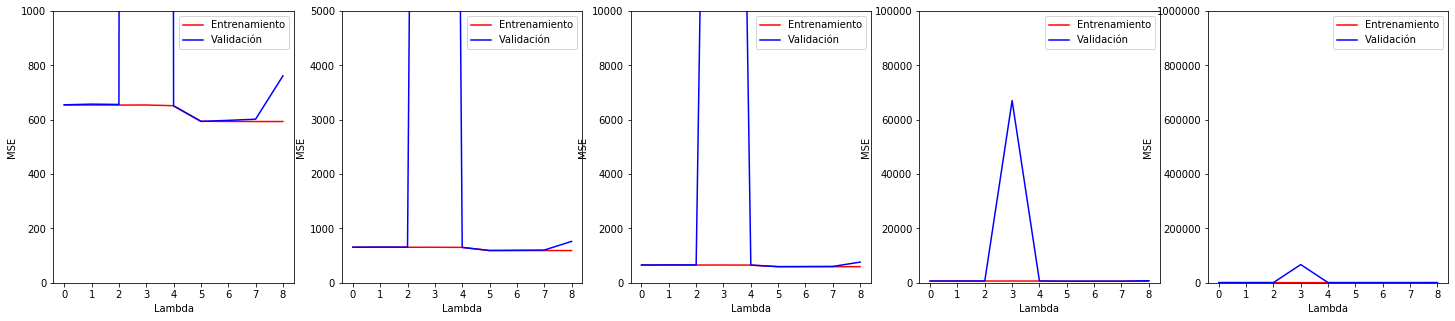

In [0]:
# Graficamos los errores medios
# Distintas escalas 
scales_2 = [1000, 5000, 10000, 100000, 1000000]
fig, ax = plt.subplots(nrows=1, ncols=len(scales_2), figsize=(25,5))
for j in range(len(scales_2)):
  ax[j].plot(range(p2_2_nlambda), housing_p2_2_mse_per_lambda_train, 'r', label='Entrenamiento')
  ax[j].plot(range(p2_2_nlambda), housing_p2_2_mse_per_lambda_test, 'b', label='Validación')
  ax[j].set_xlabel('Lambda')
  ax[j].set_ylabel('MSE')
  ax[j].set_ylim([0, scales_2[j]])
  ax[j].set_xticks(ticks=range(p2_2_nlambda))
  ax[j].legend()

Podemos observar que el error es mucho menor que por norma l2, además de que estan mas juntos los errores de el conjunto de validación y entrenamiento, al parecer en los valores mas altos de $\lambda$ se aumenta el error para validación y se disminuye el de entrenamiento, y los peores errores se encuentran dependiendo de la convergencia de LASSO lo cual dispara el error en algunas instancias.

### Parte 3: Mínimos cuadrados con expansión polinomial de grado 2 y selección de atributos.

Realizaremos selección de atributos:
* **Hacia adelante**: Probamos agregando como primer atributo a cada uno, vemos cual dio menos error en el conjunto de validación en las repeticiones y lo tomamos, posteriormente probamos agregar otro atributo probando cada uno de los restantes, vemos cual dio menos error en validación en las repeticiones y lo tomamos. Este proceso se repite hasta teminar tomando los 13 atributos y reportamos cual subconjunto fue el de menor error.

#### Selección de atributos hacia adelante.


In [0]:
# Transformamos el arreglo de atributos a un arreglo de numpy
np_attribute_header = np.array(atribute_header[:-1])

# Inicializamos nuestra lista de parametros inicial
attribute_set = np.array([])

# El grado del polinomio a usar
p3_degree = 2

# Numero de repeticiones
p3_repetitions = 10

# Numero de particiones
p3_k_folds = 5

# Inicializamos las listas donde almacenaremos los resultados por tamaño del conjunto de atributos
housing_p3_mse_per_attribute_set_train = []
housing_p3_mse_per_attribute_set_test = []

# Realizaremos 13 iteraciones pues en cada iteración agregamos un atributo y tenemos a lo mas 13 atributos
for iteration_i in range(len(np_attribute_header)):

  # Inicializamos las variables donde guardaremos los valores del que tuvo menor error en el conjunto de validación en este subconjunto
  attribute_to_insert = ''
  min_mse_per_attribute_to_insert_train = 0.0
  min_mse_per_attribute_to_insert_test = 0.0
  
  # Recorremos los atributos y revisamos cuales podemos tomar para calcular su mse
  for attribute_to_test in np_attribute_header:
    
    # Si ya tomamos al atributo lo ignoramos y pasamos al siguiente
    if attribute_set.shape[0] > 0:
      if attribute_to_test in attribute_set: 
        continue
    
    # Armamos el conjunto de atributos de prueba incluyendo este nuevo atributo para probar
    current_new_attribute_set = np.copy(attribute_set)
    current_new_attribute_set = np.append(current_new_attribute_set, attribute_to_test)
    
    # Inicializamos las listas donde almacenaremos los resultados por repetición
    housing_p3_mse_per_repetition_train = np.array([])
    housing_p3_mse_per_repetition_test = np.array([])

    # Para la validación cruzada probaremos con 10 repeticiones
    for repetition_i in range(p3_repetitions):
      
      # Obtenemos las particiones haciendo un random shuffle del data set y dividiendolo en k particiones
      shuffled_housing_data = housing_data.iloc[np.random.permutation(range(housing_data.shape[0]))].copy()
      split_shuffled_housing_data = np.array_split(shuffled_housing_data, p3_k_folds)

      # Inicializamos las listas donde almacenaremos los resultados por partición
      housing_p3_mse_per_fold_train = np.array([])
      housing_p3_mse_per_fold_test = np.array([])
        
      # Y por repeticion probaremos usar cada una de las particiones como test y las demas como entrenamiento.
      for test_partition in range(p3_k_folds):
          
        # Definimos el conjunto de validación y de entrenamiento
        house_data_test = split_shuffled_housing_data[test_partition]
        house_data_train = shuffled_housing_data.loc[~shuffled_housing_data.index.isin(house_data_test.index)]
          
        # Obtenemos nuestra matriz de atributos dependiendo de cuales son los primeros atributos
        feature_matrix_train = np.array(house_data_train[current_new_attribute_set].copy().values)
          
        # Obtenemos la matriz de diseño que obteniendo la expansion del polinomio
        design_matrix_X_train = getPoly(feature_matrix_train, p3_degree)
          
        # Obtenemos nuestro vector de Theta por minimos cuadrados simple
        theta_hat = theta_ms(design_matrix_X_train, np.array(house_data_train['MEDV'].copy().values))

        # Obtenemos la predicción para entrenamiento
        y_hat_train = linear_model_f(design_matrix_X_train, theta_hat)

        # Conjunto de Validación
        # Obtenemos nuestra matriz de atributos
        feature_matrix_test = np.array(house_data_test[current_new_attribute_set].copy().values)

        # Obtenemos la matriz de diseño que obteniendo la expansion del polinomio
        design_matrix_X_test = getPoly(feature_matrix_test, p3_degree)

        # Obtenemos la predicción
        y_hat_test = linear_model_f(design_matrix_X_test, theta_hat)

        # Suma de errores
        # La suma de errores cuadraticos para entrenamiento y validación
        sse_train = sum_square_error(house_data_train['MEDV'], y_hat_train)
        sse_test = sum_square_error(house_data_test['MEDV'], y_hat_test)

        # El error cuadrático medio para entrenamiento y validación
        mse_train = sse_train / house_data_train.shape[0]
        mse_test = sse_test / house_data_test.shape[0]

        # Agregamos a las listas de resultados por partición
        housing_p3_mse_per_fold_train = np.append(housing_p3_mse_per_fold_train, mse_train)
        housing_p3_mse_per_fold_test = np.append(housing_p3_mse_per_fold_test, mse_test)

      # Habiendo terminado las k particiones obtenemos los promedios y los agregamos a las listas de resultados por repeteción
      housing_p3_mse_per_repetition_train = np.append(housing_p3_mse_per_repetition_train, housing_p3_mse_per_fold_train.mean())
      housing_p3_mse_per_repetition_test = np.append(housing_p3_mse_per_repetition_test, housing_p3_mse_per_fold_test.mean())
      
    # Habiendo terminado las n repeticiones obtenemos los promedios y verificamos si es que es el menor error de validación para agregarlo al conjunto actual
    # Verificamos si es que es el primero en ser evaluado
    repetition_p3_mse_mean_train = housing_p3_mse_per_repetition_train.mean()
    repetition_p3_mse_mean_test = housing_p3_mse_per_repetition_test.mean()

    if (attribute_to_insert == ''):
      min_mse_per_attribute_to_insert_train = repetition_p3_mse_mean_train
      min_mse_per_attribute_to_insert_test = repetition_p3_mse_mean_test
      attribute_to_insert = attribute_to_test
    else :
      if (min_mse_per_attribute_to_insert_test > repetition_p3_mse_mean_test):
        min_mse_per_attribute_to_insert_train = repetition_p3_mse_mean_train
        min_mse_per_attribute_to_insert_test = repetition_p3_mse_mean_test
        attribute_to_insert = attribute_to_test
  # Habiendo terminado 
  print('iteration_i = {0}, attribute_to_insert = {1}, mse_train = {2}, mse_test = {3}'.format(iteration_i, attribute_to_insert, min_mse_per_attribute_to_insert_train, min_mse_per_attribute_to_insert_test))
  attribute_set = np.append(attribute_set, attribute_to_insert)
  housing_p3_mse_per_attribute_set_train.append(min_mse_per_attribute_to_insert_train)
  housing_p3_mse_per_attribute_set_test.append(min_mse_per_attribute_to_insert_test)

iteration_i = 0, attribute_to_insert = LSTAT, mse_train = 30.27368187703606, mse_test = 30.841203787499932
iteration_i = 1, attribute_to_insert = RM, mse_train = 20.916799836800674, mse_test = 22.015521155154847
iteration_i = 2, attribute_to_insert = PTRATIO, mse_train = 19.315695179208472, mse_test = 20.4456007135565
iteration_i = 3, attribute_to_insert = NOX, mse_train = 18.349040685132174, mse_test = 19.747559878095963
iteration_i = 4, attribute_to_insert = DIS, mse_train = 17.35192884768483, mse_test = 18.665324634539196
iteration_i = 5, attribute_to_insert = CRIM, mse_train = 16.335474478535147, mse_test = 17.906246043134832
iteration_i = 6, attribute_to_insert = RAD, mse_train = 15.77746290311382, mse_test = 17.58851003022331
iteration_i = 7, attribute_to_insert = CHAS, mse_train = 15.241769021041389, mse_test = 17.537411519449208
iteration_i = 8, attribute_to_insert = INDUS, mse_train = 17.312275313170275, mse_test = 19.688102341616815
iteration_i = 9, attribute_to_insert = ZN, 

En este orden se fueron agregando los atributos:

In [0]:
attribute_set

array(['LSTAT', 'RM', 'PTRATIO', 'NOX', 'DIS', 'CRIM', 'RAD', 'CHAS',
       'INDUS', 'ZN', 'TAX', 'B', 'AGE'], dtype='<U32')

Y la gráfica para determinar como se ve es:

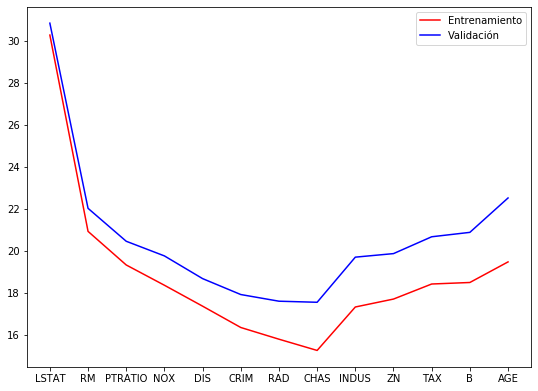

In [0]:
fig = plt.figure(figsize=(7,5))
ax=fig.add_axes([0,0,1,1])
ax.plot(attribute_set, housing_p3_mse_per_attribute_set_train, 'r', label='Entrenamiento');
ax.plot(attribute_set, housing_p3_mse_per_attribute_set_test, 'b', label='Validación');
plt.legend()
plt.show()

En este caso el error fue disminuyendo al agregar atributos, sin embargo también se puede apreciar que en un momento vuelve a subir el error, lo cual implicaría un sobreajuste debido a la complejidad del modelo.

In [0]:
# Transformarmos el arreglo de resultados para el conjunto de validación a un arreglo de numpy
np_housing_p3_mse_per_attribute_set_test = np.array(housing_p3_mse_per_attribute_set_test)
p3_min_id = np_housing_p3_mse_per_attribute_set_test.argmin()
print('El menor error Fue con el subconjunto de tamaño: {0}'.format(p3_min_id + 1))
print(attribute_set[:p3_min_id + 1])
print(np_housing_p3_mse_per_attribute_set_test.min())

El menor error Fue con el subconjunto de tamaño: 8
['LSTAT' 'RM' 'PTRATIO' 'NOX' 'DIS' 'CRIM' 'RAD' 'CHAS']
17.537411519449208


## Ejercicio 2 - Predicción de juegos
Un club del juego de Go recopiló los resultados de varias partidas entre diferentes jugadores, almacenados en el archivo juegos_entrenamiento.txt, con el objetivo de predecir el resultado de partidas futuras, ejemplos de las cuales se encuentran en el archivo juegos_validacion.txt. Los archivos juegos_entrenamiento.txt y juegos_validacion.txt contienen 3 columnas: la primera corresponde al identificador del jugador A, la segunda al identificador del jugador B y la tercera es el resultado de la partida (1 si ganó el jugador A o 0 si ganó el jugador B). En el club hay un total de D jugadores, por lo que cada identificador es un número entero entre 1 y D. La predicción del resultado de un juego se puede plantear como un problema de clasificación: dados 2 jugadores (A y B) se requiere predecir si A ganó (y = 1) o si fue B (y = 0).

Realice los siguientes ejercicios:
* Entrena y evalúa un clasificador bayesiano ingenuo. Al ser un modelo generativo (modela
la probabilidad conjunta P(x, y)), es posible generar partidas artificiales con los parámetros
calculados. Genera nuevas partidas que sigan la distribución modelada.
* Entrena y evalúa un clasificador de regresión logística. Para esto es necesario reparametrizar las entradas. Explica el procedimiento y la lógica de la reparametrización que realizaste. Selecciona y visualiza los valores de los parámetros. Grafica las curvas ROC y de precisión exhaustividad y reporta sus áreas bajo la curva.
* Compara el clasificador bayesiano ingenuo y regresión logística en este problema. ¿Qué ventajas y desventajas tienen los modelos entrenados? ¿Qué pasaría si se entrena el clasificador bayesiano ingenuo con los vectores reparametrizados o si se entrena un modelo de regresión logística usando los vectores de entrada originales? ¿Consideras que las presuposiciones de cada clasificador son apropiadas para los datos del problema? ¿Para este tipo de problemas cuál de los dos recomendarías y por qué?

* Deriva la regla de actualización para el algoritmo del descenso por gradiente de un clasificador donde $\hat{y} = sigm(\theta^T x)$ y la función de pérdida sea: 
$$
E(\theta) = \frac{1}{2}\sum_{i=1}^{n}{(\hat{y}^{(i)} - y^{(i)})}
$$
Discute las diferencias entre este clasificador y el de regresión logística y compara sus rendimientos en la tarea de predicción de juegos.




### Descarga de base de datos

In [0]:
# Descargamos la base de datos
!wget -O regl_data.zip http://turing.iimas.unam.mx/~gibranfp/cursos/aprendizaje_automatizado/data/regl_data.zip

--2020-04-17 08:27:02--  http://turing.iimas.unam.mx/~gibranfp/cursos/aprendizaje_automatizado/data/regl_data.zip
Resolving turing.iimas.unam.mx (turing.iimas.unam.mx)... 132.248.51.88
Connecting to turing.iimas.unam.mx (turing.iimas.unam.mx)|132.248.51.88|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12543 (12K) [application/zip]
Saving to: ‘regl_data.zip’

regl_data.zip       100%[===================>]  12.25K  --.-KB/s    in 0.003s  

2020-04-17 08:27:03 (3.97 MB/s) - ‘regl_data.zip’ saved [12543/12543]



In [0]:
# hacemos unzip
!unzip -o regl_data.zip

Archive:  regl_data.zip
   creating: regl_data/
  inflating: regl_data/juegos_entrenamiento.txt  
  inflating: regl_data/juegos_validacion.txt  
  inflating: regl_data/x_entrenamiento.csv  
  inflating: regl_data/x_validacion.csv  
  inflating: regl_data/y_entrenamiento.csv  
  inflating: regl_data/y_validacion.csv  


In [0]:
# Leemos las partidas de entrenamiento en un dataframe
go_matches_train = pd.read_csv('regl_data/juegos_entrenamiento.txt', header=None, delim_whitespace=True)
go_matches_train

,0,1,2
0,3,4,1
1,7,8,1
2,40,10,1
3,16,17,1
4,8,18,1
...,...,...,...
314,80,97,1
315,81,45,0
316,35,43,1
317,87,23,0


In [0]:
# Leemos las partidas de validación en un dataframe
go_matches_test = pd.read_csv('regl_data/juegos_validacion.txt', header=None, delim_whitespace=True)
go_matches_test

,0,1,2
0,35,43,1
1,45,9,0
2,55,106,0
3,35,43,1
4,35,43,1
...,...,...,...
110,60,120,1
111,101,43,1
112,55,105,0
113,7,9,0


### Parte 1. Entrena y evalúa un clasificador bayesiano ingenuo.


 Al ser un modelo generativo (modela la probabilidad conjunta P(x, y)), es posible generar partidas artificiales con los parámetros calculados. Genera nuevas partidas que sigan la distribución modelada.

Separamos la clase "gana jugador A", y la clase "gana jugador B" del conjunto de entrenamiento

In [0]:
go_matches_train_winA = go_matches_train[go_matches_train[2] == 1]
go_matches_train_winB = go_matches_train[go_matches_train[2] == 0]

Obtenemos los parametros q, para la distribución Bernoulli de la clase.

In [0]:
# q para la clase "gana jugador A"
ej2_emv_q_winA = go_matches_train_winA.shape[0] / go_matches_train.shape[0]

# q para la clase "gana jugador B"
ej2_emv_q_winB = go_matches_train_winB.shape[0] / go_matches_train.shape[0]
print('q Gana A = {0}, q Gana B = {1}'.format(ej2_emv_q_winA, ej2_emv_q_winB))

q Gana A = 0.5235109717868338, q Gana B = 0.47648902821316613


Podemos definir la distribución de los identificadores para jugador A y B con una categorica:
\begin{equation}
Cat(X_{id}^{(i)};q) = \prod_{k=1}^{D}q_{k}^{[x_{id}^{(i)}=k ]}
\end{equation}
Donde podemos estimar a $q_k$ usando el estimador de máxima verosimilitud como:
  \begin{equation}
  \begin{split}
  \hat{q}_k =& \frac{c_k}{n} \\ 
  \text{Donde $c_k$:}&\\
  c_k =& \sum_{i = 1}^{n}{[x^{(i)}_{id}=k]}
  \end{split}
  \end{equation}

In [0]:
# Calculamos las q para los atributos de "jugador A" y "jugador B", 
# para cada una de las clases "gana jugador A" y "gana jugador B"
D_players = 142
q_playerA_winA = np.zeros(D_players)
q_playerA_winB = np.zeros_like(q_playerA_winA)
q_playerB_winA = np.zeros_like(q_playerA_winA)
q_playerB_winB = np.zeros_like(q_playerA_winA)
for i in range(D_players):
  q_playerA_winA[i] = go_matches_train_winA[go_matches_train_winA[0] == (i + 1)].shape[0] / go_matches_train_winA.shape[0]
  q_playerA_winB[i] = go_matches_train_winB[go_matches_train_winB[0] == (i + 1)].shape[0] / go_matches_train_winB.shape[0]
  q_playerB_winA[i] = go_matches_train_winA[go_matches_train_winA[1] == (i + 1)].shape[0] / go_matches_train_winA.shape[0]
  q_playerB_winB[i] = go_matches_train_winB[go_matches_train_winB[1] == (i + 1)].shape[0] / go_matches_train_winB.shape[0]

Definamos la función con la que clasificamos

In [0]:
def ej2_go_win_EMV(attributes_match):
  probability_winA = ej2_emv_q_winA * q_playerA_winA[attributes_match[0] - 1] * q_playerB_winA[attributes_match[1] - 1]
  probability_winB = ej2_emv_q_winB * q_playerA_winB[attributes_match[0] - 1] * q_playerB_winB[attributes_match[1] - 1]
  if (probability_winA > probability_winB):
    return 1
  return 0

Evaluamos el porcentaje de predicciones correctas para los conjuntos de entrenamiento y validación

In [0]:
ej2_emv_y_pred_train = np.array([])
ej2_emv_y_pred_test = np.array([])

ej2_n_correct_train = 0
for i in range(go_matches_train.shape[0]):
 ej2_emv_y_pred_train = np.append(ej2_emv_y_pred_train, ej2_go_win_EMV(go_matches_train.loc[i][:2]))
 if (ej2_emv_y_pred_train[i] == go_matches_train.loc[i][2]):
   ej2_n_correct_train += 1

ej2_n_correct_test = 0
for i in range(go_matches_test.shape[0]):
 ej2_emv_y_pred_test = np.append(ej2_emv_y_pred_test, ej2_go_win_EMV(go_matches_test.loc[i][:2]))
 if (ej2_emv_y_pred_test[i] == go_matches_test.loc[i][2]):
   ej2_n_correct_test += 1

print('% Correct in Train: {0}'.format(ej2_n_correct_train * 100 /go_matches_train.shape[0]))

print('% Correct in Test: {0}'.format(ej2_n_correct_test * 100 /go_matches_test.shape[0]))

% Correct in Train: 86.52037617554859
% Correct in Test: 69.56521739130434


Ahora al estar construyendo las probabilidades $P(y)$ y $P(x|y)$, podemos generar nuevas partidas. Una forma es obtener nuestra clase, generarla aleatoreamente con una probabilidad de que sea "gana jugador A" y otra probabilidad para que sea "gana jugador B" y teniendo esa clase ahora es generar aleatoreamente, con sus respectivas probabilidades, a los atributos de "jugador A" y "jugador B".

In [0]:
# Utilizamos el generador aleatorio multinomial de numpy
rng = np.random.default_rng()

# Generaremos 10 partidas adicionales
n_matches_to_generate = 10
ej2_new_go_matches = np.empty(shape=(0,3))
for i in range(n_matches_to_generate):
  # Obtenemos la clase
  ej2_generated_class = np.array(rng.multinomial(1, [ej2_emv_q_winB, ej2_emv_q_winA], size=1))[0].argmax()
  
  # Asignamos las probabilidades de los jugadores para ser jugador A y B respectivamente para la clase "gana jugador A"
  ej2_prob_generate_player_A = q_playerA_winA
  ej2_prob_generate_player_B = q_playerB_winA

  # Si la clase generada fue "gana jugador B" las reasignamos a las correspondientes
  if (ej2_generated_class == 0):
    ej2_prob_generate_player_A = q_playerA_winB
    ej2_prob_generate_player_B = q_playerB_winB

  # Obtenemos el jugador A y el jugador B
  ej2_generated_player_A = np.array(rng.multinomial(1, ej2_prob_generate_player_A, size=1))[0].argmax() + 1
  ej2_generated_player_B = np.array(rng.multinomial(1, ej2_prob_generate_player_B, size=1))[0].argmax() + 1
  ej2_new_go_matches = np.concatenate((ej2_new_go_matches, np.array([[ej2_generated_player_A, ej2_generated_player_B, ej2_generated_class]])))

print(ej2_new_go_matches)

[[ 27.  60.   0.]
 [ 95.  51.   0.]
 [119.  93.   1.]
 [ 26. 122.   1.]
 [ 12.  18.   0.]
 [  8. 105.   1.]
 [  4. 100.   0.]
 [ 44. 100.   0.]
 [ 64.   9.   1.]
 [116. 110.   0.]]


### Parte 2. Entrena y evalúa un clasificador de regresión logística.

Para esto es necesario reparametrizar las entradas. Explica el procedimiento y la lógica de la reparametrización que realizaste. Selecciona y visualiza los valores de los parámetros. Grafica las curvas ROC y de precisión exhaustividad y reporta sus áreas bajo la curva.

#### Reparametrización


En este caso se escogió la reparametrización ustilizando variables dummy (Dummy coding), el cual consiste en utilizar una variable por cada categoria posible para los atributos categoricos, con excepción de una, la variable de referencia.
Ahora si la muestra tendrá un valor de 1 para la variable correspondiente a la categoría que tenía y ceros en las demás, y para el caso de que fuera de la categoría de referencia entonces tendrá solo 0 en todas las variables dummy.

Esta reparametrización se realiza debido a que aunque los identificadores de los jugadores son números, estos no representan una relación de orden o jerarquía como la que presentan los valores reales en algún atributo como la altura. Es decir, no es que ser el jugador 1 sea mas o menos que ser el jugador 3, bien podrían identificarse como jugador "a" y jugador "b" o "Vivian" y "Dennis". Por lo tanto el ajuste que se realiza en la estimación de parametros no debe considerar que existe esa relación de orden, no debería pensar que hay que disminuir la influencia del jugador 10000 a diferencia del jugador 3, porque como vimos esto no quiere decir que uno es mas que otro solo por su identificador.

Así se llega a que cada muestra tiene cierta "cantidad" de cada categoría y forzamos que sea absoluta, 0 si no es de esa categoría o 1 si es de esa categoria, a excepción de la categoría de referencia.

In [0]:
# Reparametrización
player_ids = go_matches_train[0].copy()
player_ids = np.append(player_ids, go_matches_train[1].copy())
player_ids = np.append(player_ids, go_matches_test[0].copy())
player_ids = np.append(player_ids, go_matches_test[1].copy())
player_ids = np.unique(player_ids)
print(player_ids)
print(player_ids.shape[0])

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142]
142


In [0]:
# Hay 142 id de jugadores entonces habrá 141 nuevas variables dummy para jugador_A y 141 variables para jugador_B.
# En total tendremos 282 atributos. Dejaremos como variable de referencia al id = 1, el cual sera identificado al tener todos los parametros en 0

# Reparametrizamos la entrada de entrenamiento
coded_go_matches_train = np.empty((0,283))
for i in range(go_matches_train.shape[0]):
  coded_features_i = np.zeros((283,))

  # Indexamos desde 0 a los indices de los jugadores
  curr_player_A_id = go_matches_train.loc[i][0] - 1
  
  # Si el jugador A NO es el jugador con indice 1, que ahora paso a ser 0, 
  # entonces se coloca un 1 en la variable dummy que le corresponde
  if (curr_player_A_id != 0):
    coded_features_i[curr_player_A_id] = 1
  
  # Realizamos lo mismo para el jugador B pero lo ubicamos en las siguientes 141
  # variables entonces se le suma 141 al id para ubicarlo
  curr_player_B_id = go_matches_train.loc[i][1] - 1
  if (curr_player_B_id != 0):
    coded_features_i[141 + curr_player_B_id] = 1
  
  # Guardamos el valor de y, la clase, si gano el jugador A o B
  coded_features_i[282] = go_matches_train.loc[i][2]
  coded_go_matches_train = np.concatenate((coded_go_matches_train, np.array([coded_features_i])))
pd.DataFrame(coded_go_matches_train)

,0,1,2,3,4,5,6,7,8,9,...,273,274,275,276,277,278,279,280,281,282
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
316,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
317,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
# Reparametrizamos la entrada de validación
coded_go_matches_test = np.empty((0,283))
for i in range(go_matches_test.shape[0]):
  coded_features_i = np.zeros((283,))
  curr_player_A_id = go_matches_test.loc[i][0] - 1
  if (curr_player_A_id != 0):
    coded_features_i[curr_player_A_id] = 1
  curr_player_B_id = go_matches_test.loc[i][1] - 1
  if (curr_player_B_id != 0):
    coded_features_i[141 + curr_player_B_id] = 1
  coded_features_i[282] = go_matches_test.loc[i][2]
  coded_go_matches_test = np.concatenate((coded_go_matches_test, np.array([coded_features_i])))
pd.DataFrame(coded_go_matches_test)

,0,1,2,3,4,5,6,7,8,9,...,273,274,275,276,277,278,279,280,281,282
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
112,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
113,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Entrenamiento

Se realizará el entrenamiento de un modelo de regresión logística utilizando descenso por gradiente con una tasa de aprendizaje $\alpha=0.05$, un vector incial aleatorio para $\hat{\theta}$, error cuadrático medio como función de perdida y realizando 10000 iteraciones.

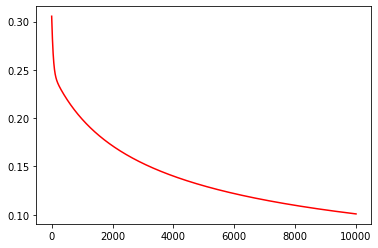

In [0]:
# Inicializamos nuestra taza de aprendizaje
ej2_alpha = 0.05

# Inicializamos el numero de iteraciones
ej2_iterations = 10000

# Inicializamos nuestro vector theta
ej2_theta_hat = np.random.rand(283)

# Obtenemos nuestros vectores de atributos
ej2_features_x_train = coded_go_matches_train[:,:282]

# Obtenemos nuestro y verdadero
ej2_y_true_train = np.ravel(coded_go_matches_train[:,282:])

# Obtenemos la matriz de diseño
ej2_design_matrix_x_train = np.hstack((np.ones((ej2_features_x_train.shape[0], 1)), ej2_features_x_train))

# Realizamos una predicción con el vector theta actual
ej2_y_pred_train = logistic_model_f(ej2_design_matrix_x_train, ej2_theta_hat)

# Obtenemos el valor de la pérdida
ej2_loss_i = sum_square_error(ej2_y_true_train, ej2_y_pred_train) / ej2_y_pred_train.shape[0]

# Guardamos el historial de la perdida
ej2_loss_hist = np.array([ej2_loss_i])

for i in range(ej2_iterations):
  
  # Obtenemos el gradiente 
  ej2_grad_i = (ej2_design_matrix_x_train.T @ (ej2_y_pred_train - ej2_y_true_train)) / ej2_y_pred_train.shape[0]
  
  # Actualizamos el vector theta
  ej2_theta_hat = ej2_theta_hat - ej2_alpha * ej2_grad_i

  # Realizamos una predicción con el vector theta actual
  ej2_y_pred_train = logistic_model_f(ej2_design_matrix_x_train, ej2_theta_hat)

  # Obtenemos el valor de la pérdida
  ej2_loss_i = sum_square_error(ej2_y_true_train, ej2_y_pred_train) / ej2_y_pred_train.shape[0]

  # Guardamos el valor de la pérdida 
  ej2_loss_hist = np.append(ej2_loss_hist, ej2_loss_i)  

# Graficamos el historico de la pérdida
plt.figure()
plt.plot(range(len(ej2_loss_hist)), ej2_loss_hist, 'r')
plt.show()

#### Gráficamos la curva ROC

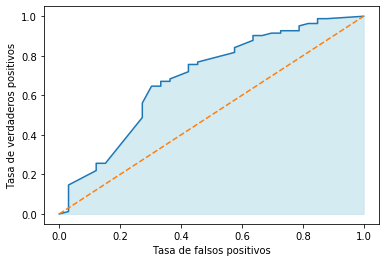

Area bajo la curva ROC = 0.6888396156688841


In [0]:
# Obtenemos nuestros vectores de atributos del conjunto de validación
ej2_features_x_test = coded_go_matches_test[:,:282]

# Obtenemos nuestro y verdadero
ej2_y_true_test = np.ravel(coded_go_matches_test[:,282:])

# Obtenemos la matriz de diseño
ej2_design_matrix_x_test = np.hstack((np.ones((ej2_features_x_test.shape[0], 1)), ej2_features_x_test))

# Obtenemos la predicción para el conjunto de validación
ej2_y_pred_test = logistic_model_f(ej2_design_matrix_x_test, ej2_theta_hat)

# Calculamos las tasas de verdaderos positivos y de falsos positivos para cada umbral.
ej2_rtps, ej2_rfps = roc(ej2_y_pred_test, ej2_y_true_test)

# Agregamos el punto inicial (0,0) 
ej2_rtps = np.append(np.zeros(1), ej2_rtps)
ej2_rfps = np.append(np.zeros(1), ej2_rfps)

# Graficamos la curva ROC
plt.plot(ej2_rfps, ej2_rtps)
plt.plot([0, 1], [0, 1], '--')
plt.fill_between(ej2_rfps, ej2_rtps, 0, alpha=0.5, color = 'lightblue')
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.show()

# Reportamos el area bajo la curva
print('Area bajo la curva ROC = {0}'.format(aucrocprecex(ej2_rfps, ej2_rtps, 0.0)))

#### Graficamos la curva de precisión exhaustividad

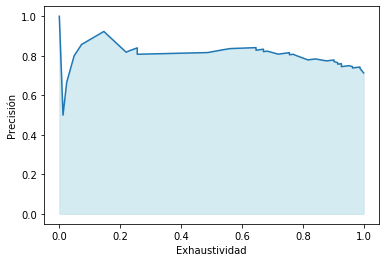

Area bajo la curva Exhaustividad = 0.8115270902556035


In [0]:
# Calculamos la precisión y exhaustividad para cada umbral.
ej2_exha_val, ej2_prec_val = prec_exha(ej2_y_pred_test, ej2_y_true_test)

# Agregamos el punto inicial (0,1) 
ej2_exha_val = np.append(np.zeros(1), ej2_exha_val)
ej2_prec_val = np.append(np.ones(1), ej2_prec_val)

# Graficamos la curva de exhaustividad
plt.plot(ej2_exha_val, ej2_prec_val)
plt.fill_between(ej2_exha_val, ej2_prec_val, 0, alpha=0.5, color = 'lightblue')
plt.xlabel('Exhaustividad')
plt.ylabel('Precisión')
plt.show()

# Reportamos el area bajo la curva
print('Area bajo la curva Exhaustividad = {0}'.format(aucrocprecex(ej2_exha_val, ej2_prec_val, 1.0)))

### Parte 3. Compara el clasificador bayesiano ingenuo y regresión logística en este problema. 

#### ¿Qué ventajas y desventajas tienen los modelos entrenados? 


* **Clasificador Bayesiano Ingenuo**: 
  * Ventajas: utiliza las entradas sin requerir una reparametrización, es decir podemos definir una distribución categorica. Otra ventaja que podríamos mencionar es que es relativamente simple y rápido de desarrollar. Y por último podemos generar nuevas partidas al ser un modelo generativo.
  * Desventajas: Al ser la versión por máxima verosimilitud, no se tiene mucho control sobre el entrenamiento, es decir no hay forma de realizar ajustes de hyperparametros o de explorar otros valores que impacten a su rendimiento. Otra desventaja es que asume que todos los parametros son condicionalmente independientes dada la clase por lo que si no es una representación muy cercana a la realidad esto sera perjudicial para el rendimiento. En este caso por ejemplo no se mantiene dicha afirmación ya que el saber que gano el jugador A o el jugador B, no nos aporta completamente lo necesario para determinar que valor ocupara los atributos de los identificadores del jugador A o jugador B, incluso saber el identificador de alguno de los dos nos dará mas información puesto que al menos sabemos que deben ser dos identificadores distintos y si sabemos uno, sabemos que el otro al menos no es ese.
* **Clasificador Regresión Logística**: 
  * Ventajas: El entrenamiento que realiza ajusta sus parametros para aumentar la verosimilitud aún si los parametros llegan a ser inconsistentes con la independencia condicional de los atributos, es decir este modelo puede tener un menor sesgo de predicción ya que obtiene los parametros a partir de los datos sin realizar una fuerte suposición a diferencia de Naive Bayes. Es mas robusto.
  * Desventajas:  Entradas categoricas requieren una reparametrización. Es mas complejo.

#### ¿Qué pasaría si se entrena el clasificador bayesiano ingenuo con los vectores reparametrizados o si se entrena un modelo de regresión logística usando los vectores de entrada originales? 

En ambos casos habría algún grado de inconsistencia con las suposiciones de los clasificadores.

* Para el caso del clasificador bayesiano, al asumir independencia condicional entre los atributos, al tener dicha reparametrización donde las variables dummy codifican que jugador es el jugador A y cual el B es claro que teniendo las variables de los atributos excepto una podemos inferir que valor tiene aún sin revisar el valor de la clase.El clasificador entonces interpretará una forma distinta de la realidad lo cual perjudicaría su desempeño.

* Para el caso del modelo de regresión logística, los valores directos de entrada harán que el modelo interprete una influencia por parte de los identificadores que realmente no tienen. Es decir, el modelo considerara al identificador con un valor numerico con magnitud, una magnitud que buscará ajustar y será dependiente de que tan grande o pequeño sea, lo cual es algo que no es consistente con la realidad ya que no influye realmente el valor del identificador. Esto hará entonces que el modelo llegue a ajustes con malos desempeños porque asume esa influencia.

#### ¿Consideras que las presuposiciones de cada clasificador son apropiadas para los datos del problema? 

En el caso del clasificador bayesiano no es apropiada del todo, la desventaja es que no hay forma de tratar de ajustar el sesgo resultante de suponer la independencia condicional de los atributos dados la clase, que para estos datos en particular no es cierto necesariamente. 

En el caso del clasificador de regresión lineal el sesgo será tratado con respecto a los datos, lo cual es mas apropiado, la cuestión es revisar y elegir la codificación y parametros tales que mejoren el desempeño con respecto al clasificador bayesiano.

#### ¿Para este tipo de problemas cuál de los dos recomendarías y por qué?

Asumiendo las características de este problema como el no tener una clara independecia condicional entre los parametros, tener datos que puedan aportar al ajuste del modelo para predecir y que no represente un gran inconvenitne la utlización de una reparametrización, consideraría que la recomendación para una mejor interpretación del problema es usar un modelo de regresión logística que permita una mejor exploración en la relación de atributos y su ajuste para la predicción lo cual puede llevar a una mejor representación del problema que lleve incluso a considerar otras opciones de modelos y parametrización que se asemejen mas a la realidad y tengan un mejor desempeño.

## Ejercicio 3 - Regresión logística vs clasificador bayesiano ingenuo

Compara los métodos de regresión logística y el clasificador bayesiano ingenuo en las siguientes tareas:

* Clasificación de spam.
* Clasificación de tumores de seno.

Discute qué modelo seleccionarías y por qué. Todos los modelos deberán ser evaluados con 10
repeticiones de validación cruzada estratificada de 5 particiones.

### Clasificación SPAM

#### Obtención de la base de datos

In [0]:
!wget -O spam.csv "https://turing.iimas.unam.mx/~gibranfp/cursos/aprendizaje_automatizado/data/spam.csv"

--2020-04-17 08:27:05--  https://turing.iimas.unam.mx/~gibranfp/cursos/aprendizaje_automatizado/data/spam.csv
Resolving turing.iimas.unam.mx (turing.iimas.unam.mx)... 132.248.51.88
Connecting to turing.iimas.unam.mx (turing.iimas.unam.mx)|132.248.51.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20699730 (20M) [text/csv]
Saving to: ‘spam.csv’

spam.csv            100%[===================>]  19.74M  4.26MB/s    in 5.0s    

2020-04-17 08:27:11 (3.92 MB/s) - ‘spam.csv’ saved [20699730/20699730]



In [0]:
spam_data = pd.read_csv('spam.csv', sep=' ', header=None)
spam_data

,0,1,2,3,4,5,6,7,8,9,...,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5167,0,0,0,0,0,0,0,0,4,0,...,0,0,0,0,0,0,0,0,0,0
5168,0,0,0,0,3,4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5169,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5170,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Clasificador Bayesiano Ingenuo

In [0]:
# Definimos la función del EMV, devuelve 1 si es clasificado como SPAM o 0 en otro caso
def spamEMV(attribute_vector, emv_q_spam, emv_q_no_spam, emv_q_words_in_spam, emv_q_words_in_no_spam):
  probability_is_spam = emv_q_spam * np.power(emv_q_words_in_spam, attribute_vector).prod()
  probability_is_not_spam = emv_q_no_spam * np.power(emv_q_words_in_no_spam, attribute_vector).prod()
  if (probability_is_spam > probability_is_not_spam):
    return 1
  return 0

##### Estimación de parametros y Reporte de porcentaje de predicciones correctas

In [0]:
# Inicializamos el numero de repeticiones
ej3_spam_repetitions = 10

# Inicializamos el valor de k para las particiones
ej3_spam_k_fold = 5

# Inicializamos las listas donde almacenaremos los resultados
ej3_spam_percentage_per_repetition_train = []
ej3_spam_percentage_per_repetition_test = []

# Recorremos las 10 repeticiones
for ej3_spam_repetition_i in range(ej3_spam_repetitions):
  
  # Hacemos un random shuffle del data set
  shuffled_spam_data = spam_data.iloc[np.random.permutation(range(spam_data.shape[0]))].copy()
  
  # Al usar una partición estratificada haremos una division entre los datos por clase
  shuffled_spam_data_class_spam = shuffled_spam_data[shuffled_spam_data[2000] == 1]
  shuffled_spam_data_class_no_spam = shuffled_spam_data[shuffled_spam_data[2000] == 0]

  # Por repeticion ahora haremos un split en k particiones en la clase spam y la no spam
  split_shuffled_spam_data_class_spam = np.array_split(shuffled_spam_data_class_spam, ej3_spam_k_fold)
  split_shuffled_spam_data_class_no_spam = np.array_split(shuffled_spam_data_class_no_spam, ej3_spam_k_fold)
  
  # Inicializamos las listas donde almacenaremos los resultados por partición
  ej3_spam_percentage_per_fold_train = []
  ej3_spam_percentage_per_fold_test = []
  
  # Recorremos las particiones
  for test_partition in range(ej3_spam_k_fold):
    # Definimos el conjunto de validación y de entrenamiento por clase
    spam_data_class_spam_test = split_shuffled_spam_data_class_spam[test_partition]
    spam_data_class_spam_train = shuffled_spam_data_class_spam.loc[~shuffled_spam_data_class_spam.index.isin(spam_data_class_spam_test.index)]

    spam_data_class_no_spam_test = split_shuffled_spam_data_class_no_spam[test_partition]
    spam_data_class_no_spam_train = shuffled_spam_data_class_no_spam.loc[~shuffled_spam_data_class_no_spam.index.isin(spam_data_class_no_spam_test.index)]
    
    # Agrupamos el conjunto de validacion y entrenamiento
    spam_current_partition_test = pd.concat([spam_data_class_spam_test, spam_data_class_no_spam_test])
    spam_current_partition_train = pd.concat([spam_data_class_spam_train, spam_data_class_no_spam_train])
    
    # Estimamos el parametro q por clase
    # Obtenemos el total de elementos en el conjunto de datos
    emv_q_class_spam_curr_part = spam_data_class_spam_train.shape[0] / spam_current_partition_train.shape[0] 
    emv_q_class_no_spam_curr_part = spam_data_class_no_spam_train.shape[0] / spam_current_partition_train.shape[0]
   
    # Estimamos los parametros para los atributos utilizando una distribución multinomial
    # para la clase spam
    word_occurrences_in_class_spam = spam_data_class_spam_train.iloc[:,:-1].sum(axis=0)
    emv_q_words_in_class_spam = word_occurrences_in_class_spam / word_occurrences_in_class_spam.sum()
    # para la clase no spam
    word_occurrences_in_class_no_spam = spam_data_class_no_spam_train.iloc[:,:-1].sum(axis=0)
    emv_q_words_in_class_no_spam = word_occurrences_in_class_no_spam / word_occurrences_in_class_no_spam.sum()

    # Obtenemos las predicciones correctas en el conjunto de entrenamiento
    correct_predictions_in_partition_train = 0
    for prediction_i in range(spam_current_partition_train.shape[0]):
      current_prediction_result = spamEMV(spam_current_partition_train.iloc[prediction_i,:-1], emv_q_class_spam_curr_part, emv_q_class_no_spam_curr_part, emv_q_words_in_class_spam, emv_q_words_in_class_no_spam)
      if (current_prediction_result == spam_current_partition_train.iloc[prediction_i,-1]):
        correct_predictions_in_partition_train += 1


    # Obtenemos las predicciones correctas en el conjunto de validacion
    correct_predictions_in_partition_test = 0
    for prediction_i in range(spam_current_partition_test.shape[0]):
      current_prediction_result = spamEMV(spam_current_partition_test.iloc[prediction_i,:-1], emv_q_class_spam_curr_part, emv_q_class_no_spam_curr_part, emv_q_words_in_class_spam, emv_q_words_in_class_no_spam)
      if (current_prediction_result == spam_current_partition_test.iloc[prediction_i,-1]):
        correct_predictions_in_partition_test += 1

    print ('Repetition {0}/{1} - Partition {2}/{3}'.format( (ej3_spam_repetition_i + 1), ej3_spam_repetitions, (test_partition + 1), ej3_spam_k_fold) )
    # Guardamos los resultados por particion
    ej3_spam_percentage_per_fold_train.append(correct_predictions_in_partition_train * 100 / spam_current_partition_train.shape[0])
    ej3_spam_percentage_per_fold_test.append(correct_predictions_in_partition_test * 100 / spam_current_partition_test.shape[0])
  
  # Guardamos los promedios por repeticion
  ej3_spam_percentage_per_repetition_train.append(np.array(ej3_spam_percentage_per_fold_train).mean())
  ej3_spam_percentage_per_repetition_test.append(np.array(ej3_spam_percentage_per_fold_test).mean())

# Reportamos los resultados promediados de los porcentajes de predicciones correctas por repeticion
print('% Correct in Train: {0}'.format(np.mean(ej3_spam_percentage_per_repetition_train)))
print('% Correct in Test: {0}'.format(np.mean(ej3_spam_percentage_per_repetition_test)))

Repetition 1/10 - Partition 1/5
Repetition 1/10 - Partition 2/5
Repetition 1/10 - Partition 3/5
Repetition 1/10 - Partition 4/5
Repetition 1/10 - Partition 5/5
Repetition 2/10 - Partition 1/5
Repetition 2/10 - Partition 2/5
Repetition 2/10 - Partition 3/5
Repetition 2/10 - Partition 4/5
Repetition 2/10 - Partition 5/5
Repetition 3/10 - Partition 1/5
Repetition 3/10 - Partition 2/5
Repetition 3/10 - Partition 3/5
Repetition 3/10 - Partition 4/5
Repetition 3/10 - Partition 5/5
Repetition 4/10 - Partition 1/5
Repetition 4/10 - Partition 2/5
Repetition 4/10 - Partition 3/5
Repetition 4/10 - Partition 4/5
Repetition 4/10 - Partition 5/5
Repetition 5/10 - Partition 1/5
Repetition 5/10 - Partition 2/5
Repetition 5/10 - Partition 3/5
Repetition 5/10 - Partition 4/5
Repetition 5/10 - Partition 5/5
Repetition 6/10 - Partition 1/5
Repetition 6/10 - Partition 2/5
Repetition 6/10 - Partition 3/5
Repetition 6/10 - Partition 4/5
Repetition 6/10 - Partition 5/5
Repetition 7/10 - Partition 1/5
Repetiti

#### Clasificador por regresión logística

In [0]:
# Inicializamos nuestra taza de aprendizaje
ej3_alpha = 0.05

# Inicializamos el numero de iteraciones
ej3_iterations = 10000

# Inicializamos el numero de repeticiones
ej3_lgreg_repetitions = 10

# Inicializamos el valor de k para las particiones
ej3_lgreg_k_fold = 5

# Inicializamos las listas donde almacenaremos los resultados
ej3_lgreg_percentage_per_repetition_train = []
ej3_lgreg_percentage_per_repetition_test = []

# Recorremos las 10 repeticiones
for ej3_lgreg_repetition_i in range(ej3_lgreg_repetitions):
  
  # Hacemos un random shuffle del data set
  shuffled_spam_data = spam_data.iloc[np.random.permutation(range(spam_data.shape[0]))].copy()
  
  # Al usar una partición estratificada haremos una division entre los datos por clase
  shuffled_spam_data_class_spam = shuffled_spam_data[shuffled_spam_data.iloc[:,-1] == 1]
  shuffled_spam_data_class_no_spam = shuffled_spam_data[shuffled_spam_data.iloc[:,-1] == 0]

  # Por repeticion ahora haremos un split en k particiones en la clase spam y la no spam
  split_shuffled_spam_data_class_spam = np.array_split(shuffled_spam_data_class_spam, ej3_spam_k_fold)
  split_shuffled_spam_data_class_no_spam = np.array_split(shuffled_spam_data_class_no_spam, ej3_spam_k_fold)
  
  # Inicializamos las listas donde almacenaremos los resultados por partición
  ej3_lgreg_percentage_per_fold_train = []
  ej3_lgreg_percentage_per_fold_test = []
  
  # Recorremos las particiones
  for test_partition in range(ej3_lgreg_k_fold):
    # Definimos el conjunto de validación y de entrenamiento por clase
    spam_data_class_spam_test = split_shuffled_spam_data_class_spam[test_partition]
    spam_data_class_spam_train = shuffled_spam_data_class_spam.loc[~shuffled_spam_data_class_spam.index.isin(spam_data_class_spam_test.index)]

    spam_data_class_no_spam_test = split_shuffled_spam_data_class_no_spam[test_partition]
    spam_data_class_no_spam_train = shuffled_spam_data_class_no_spam.loc[~shuffled_spam_data_class_no_spam.index.isin(spam_data_class_no_spam_test.index)]
    
    # Agrupamos el conjunto de validacion y entrenamiento
    spam_current_partition_test = pd.concat([spam_data_class_spam_test, spam_data_class_no_spam_test])
    spam_current_partition_train = pd.concat([spam_data_class_spam_train, spam_data_class_no_spam_train])

    # Inicializamos nuestro vector theta
    ej3_theta_hat = np.random.rand(spam_current_partition_train.shape[1])

    # Obtenemos nuestros vectores de atributos
    ej3_features_x_train = spam_current_partition_train.iloc[:,:-1]

    # Obtenemos nuestro y verdadero
    ej3_y_true_train = np.ravel(spam_current_partition_train.iloc[:,-1:])

    # Obtenemos la matriz de diseño
    ej3_design_matrix_x_train = np.hstack((np.ones((ej3_features_x_train.shape[0], 1)), ej3_features_x_train))

    # Realizamos una predicción con el vector theta actual
    ej3_y_pred_train = logistic_model_f(ej3_design_matrix_x_train, ej3_theta_hat)

    # Obtenemos el valor de la pérdida
    ej3_loss_i = sum_square_error(ej3_y_true_train, ej3_y_pred_train) / ej3_y_pred_train.shape[0]

    # Guardamos el historial de la perdida
    ej3_loss_hist = np.array([ej3_loss_i])

    for i in range(ej3_iterations):
      
      # Obtenemos el gradiente 
      ej3_grad_i = (ej3_design_matrix_x_train.T @ (ej3_y_pred_train - ej3_y_true_train)) / ej3_y_pred_train.shape[0]
      
      # Actualizamos el vector theta
      ej3_theta_hat = ej3_theta_hat - ej3_alpha * ej3_grad_i

      # Realizamos una predicción con el vector theta actual
      ej3_y_pred_train = logistic_model_f(ej3_design_matrix_x_train, ej3_theta_hat)

      # Obtenemos el valor de la pérdida
      ej3_loss_i = sum_square_error(ej3_y_true_train, ej3_y_pred_train) / ej3_y_pred_train.shape[0]

      # Guardamos el valor de la pérdida 
      ej3_loss_hist = np.append(ej3_loss_hist, ej3_loss_i)  

    # Obtenemos las predicciones correctas en el conjunto de entrenamiento con un threshold promediado
    mean_prob = np.mean(ej3_y_pred_train)
    correct_predictions_in_partition_train = 0
    for prediction_i in range(spam_current_partition_train.shape[0]):
      current_prediction_result = 0
      if (ej3_y_pred_train[prediction_i] >= mean_prob):
        current_prediction_result = 1
      if (current_prediction_result == spam_current_partition_train.iloc[prediction_i,-1]):
        correct_predictions_in_partition_train += 1
    
    # Obtenemos las predicciones correctas en el conjunto de validacion
    # Obtenemos nuestros vectores de atributos
    ej3_features_x_test = spam_current_partition_test.iloc[:,:-1]

    # Obtenemos nuestro y verdadero
    ej3_y_true_test = np.ravel(spam_current_partition_test.iloc[:,-1:])

    # Obtenemos la matriz de diseño
    ej3_design_matrix_x_test = np.hstack((np.ones((ej3_features_x_test.shape[0], 1)), ej3_features_x_test))

    # Realizamos una predicción con el vector theta actual
    ej3_y_pred_test = logistic_model_f(ej3_design_matrix_x_test, ej3_theta_hat)

    # Obtenemos las predicciones correctas en el conjunto de validacion por threshold posible
    mean_prob = np.mean(ej3_y_pred_test)
    correct_predictions_in_partition_test = 0
    for prediction_i in range(spam_current_partition_test.shape[0]):
      current_prediction_result = 0
      if (ej3_y_pred_test[prediction_i] >= mean_prob):
        current_prediction_result = 1
      if (current_prediction_result == spam_current_partition_test.iloc[prediction_i,-1]):
          correct_predictions_in_partition_test += 1

    # Guardamos los resultados por particion
    ej3_lgreg_percentage_per_fold_train.append(correct_predictions_in_partition_train * 100 / spam_current_partition_train.shape[0])
    ej3_lgreg_percentage_per_fold_test.append(correct_predictions_in_partition_test * 100 / spam_current_partition_test.shape[0])
    print ('Repetition {0}/{1} - Partition {2}/{3}'.format( (ej3_lgreg_repetition_i + 1), ej3_lgreg_repetitions, (test_partition + 1), ej3_lgreg_k_fold) )
  # Guardamos los promedios por repeticion
  ej3_lgreg_percentage_per_repetition_train.append(np.array(ej3_lgreg_percentage_per_fold_train).mean())
  ej3_lgreg_percentage_per_repetition_test.append(np.array(ej3_lgreg_percentage_per_fold_test).mean())

# Reportamos los resultados promediados de los porcentajes de predicciones correctas por repeticion
print('% Correct in Train: {0}'.format(np.mean(ej3_lgreg_percentage_per_repetition_train)))
print('% Correct in Test: {0}'.format(np.mean(ej3_lgreg_percentage_per_repetition_test)))

Repetition 1/10 - Partition 1/5
Repetition 1/10 - Partition 2/5
Repetition 1/10 - Partition 3/5
Repetition 1/10 - Partition 4/5
Repetition 1/10 - Partition 5/5
Repetition 2/10 - Partition 1/5
Repetition 2/10 - Partition 2/5
Repetition 2/10 - Partition 3/5
Repetition 2/10 - Partition 4/5
Repetition 2/10 - Partition 5/5
Repetition 3/10 - Partition 1/5
Repetition 3/10 - Partition 2/5
Repetition 3/10 - Partition 3/5
Repetition 3/10 - Partition 4/5
Repetition 3/10 - Partition 5/5
Repetition 4/10 - Partition 1/5
Repetition 4/10 - Partition 2/5
Repetition 4/10 - Partition 3/5
Repetition 4/10 - Partition 4/5
Repetition 4/10 - Partition 5/5
Repetition 5/10 - Partition 1/5
Repetition 5/10 - Partition 2/5
Repetition 5/10 - Partition 3/5
Repetition 5/10 - Partition 4/5
Repetition 5/10 - Partition 5/5
Repetition 6/10 - Partition 1/5
Repetition 6/10 - Partition 2/5
Repetition 6/10 - Partition 3/5
Repetition 6/10 - Partition 4/5
Repetition 6/10 - Partition 5/5
Repetition 7/10 - Partition 1/5
Repetiti

#### Discusión

En esta instancia específica del problema con las implementaciones anteriores, el clasificador que utiliza un modelo de regresión logística tiene mejores resultados en porcentajes de predicciones correctas en los conjuntos de entrenamiento y de validación. Sin embargo esto requirió de una extensa y tardada exploración de parametros como las iteraciones en el descenso por gradiente, la tasa de aprendizaje y la validación cruzada.

Los resultados que ofrece el modelo mayesiano son lo suficientemente buenos para considerarlo como una excelente alternativa y sería la recomendación para esta instancia del problema.

Otro aspecto que al considerar puede nutrir la discusión es la independencia condicional de los parametros dada la clase que asume el clasificador bayesiano, la cual podríamos aceptar ya que el valor de la presencia de una palabra en específico es minoritariamente influenciado por los demas atributos dado que ya sabemos si es SPAM o no.

### Clasificación de tumores de seno

#### Obtenemos la base de datos

In [0]:
!wget -O breast-cancer-wisconsin.data http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data

--2020-04-17 09:56:27--  http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19889 (19K) [application/x-httpd-php]
Saving to: ‘breast-cancer-wisconsin.data’

breast-cancer-wisco 100%[===================>]  19.42K  --.-KB/s    in 0.07s   

2020-04-17 09:56:27 (275 KB/s) - ‘breast-cancer-wisconsin.data’ saved [19889/19889]



In [0]:
# Leemos el contenido
breastcancer_data = pd.read_csv('breast-cancer-wisconsin.data', header=None)

# Obtenemos los registros completos
complete_registers_breastcancer_data = breastcancer_data[breastcancer_data[6] != "?"].copy()
complete_registers_breastcancer_data[6] = complete_registers_breastcancer_data[6].astype('int64')
complete_registers_breastcancer_data

# Obtenemos el valor mas frecuente
method3_mode_value = complete_registers_breastcancer_data[6].mode()[0]

# Completamos el dataset 
breastcancer_filled = breastcancer_data.copy()
breastcancer_filled = breastcancer_filled.replace("?", method3_mode_value)
breastcancer_filled = breastcancer_filled.astype('int64')

# Prescindimos del ID como atributo
breastcancer_filled = breastcancer_filled.drop(columns=0)

# Cambiamos La representación de benigno y maligno a 0 y 1 respectivamente
breastcancer_filled.loc[breastcancer_filled[10] == 2, 10] = 0
breastcancer_filled.loc[breastcancer_filled[10] == 4, 10] = 1
breastcancer_filled

,1,2,3,4,5,6,7,8,9,10
0,5,1,1,1,2,1,3,1,1,0
1,5,4,4,5,7,10,3,2,1,0
2,3,1,1,1,2,2,3,1,1,0
3,6,8,8,1,3,4,3,7,1,0
4,4,1,1,3,2,1,3,1,1,0
...,...,...,...,...,...,...,...,...,...,...
694,3,1,1,1,3,2,1,1,1,0
695,2,1,1,1,2,1,1,1,1,0
696,5,10,10,3,7,3,8,10,2,1
697,4,8,6,4,3,4,10,6,1,1


#### Clasificador Bayesiano Ingenuo

In [0]:
# Definimos la función del EMV, devuelve 1 si es clasificado como maligno o 0 en otro caso
def breastcancerEMV(attribute_vector, emv_q_malign, emv_q_benign, emv_q_attr_in_malign, emv_q_attr_in_benign):
  probability_is_malign = emv_q_malign * np.power(emv_q_attr_in_malign, attribute_vector).prod()
  probability_is_benign = emv_q_benign * np.power(emv_q_attr_in_benign, attribute_vector).prod()
  if (probability_is_malign > probability_is_benign):
    return 1
  return 0

Estimación de parametros y reporte de porcentajes de predicciones correctas

In [0]:
# Inicializamos el numero de repeticiones
ej3_breastc_repetitions = 10

# Inicializamos el valor de k para las particiones
ej3_breastc_k_fold = 5

# Inicializamos las listas donde almacenaremos los resultados
ej3_breastc_percentage_per_repetition_train = []
ej3_breastc_percentage_per_repetition_test = []

# Recorremos las 10 repeticiones
for ej3_breastc_repetition_i in range(ej3_breastc_repetitions):
  
  # Hacemos un random shuffle del data set
  shuffled_breastc_data = breastcancer_filled.iloc[np.random.permutation(range(breastcancer_filled.shape[0]))].copy()
  
  # Al usar una partición estratificada haremos una division entre los datos por clase
  shuffled_breastc_data_malign = shuffled_breastc_data[shuffled_breastc_data[10] == 1]
  shuffled_breastc_data_benign = shuffled_breastc_data[shuffled_breastc_data[10] == 0]

  # Por repeticion ahora haremos un split en k particiones en la clase maligno y benigno
  split_shuffled_breastc_data_malign = np.array_split(shuffled_breastc_data_malign, ej3_breastc_k_fold)
  split_shuffled_breastc_data_benign = np.array_split(shuffled_breastc_data_benign, ej3_breastc_k_fold)
  
  # Inicializamos las listas donde almacenaremos los resultados por partición
  ej3_breastc_percentage_per_fold_train = []
  ej3_breastc_percentage_per_fold_test = []
  
  # Recorremos las particiones
  for test_partition in range(ej3_breastc_k_fold):
    # Definimos el conjunto de validación y de entrenamiento por clase
    breastc_data_malign_test = split_shuffled_breastc_data_malign[test_partition]
    breastc_data_malign_train = shuffled_breastc_data_malign.loc[~shuffled_breastc_data_malign.index.isin(breastc_data_malign_test.index)]

    breastc_data_benign_test = split_shuffled_breastc_data_benign[test_partition]
    breastc_data_benign_train = shuffled_breastc_data_benign.loc[~shuffled_breastc_data_benign.index.isin(breastc_data_benign_test.index)]
    
    # Agrupamos el conjunto de validacion y entrenamiento
    breastc_current_partition_test = pd.concat([breastc_data_malign_test, breastc_data_benign_test])
    breastc_current_partition_train = pd.concat([breastc_data_malign_train, breastc_data_benign_train])
    
    # Estimamos el parametro q por clase
    # Obtenemos el total de elementos en el conjunto de datos
    emv_q_malign_curr_part = breastc_data_malign_train.shape[0] / breastc_current_partition_train.shape[0] 
    emv_q_benign_curr_part = breastc_data_benign_train.shape[0] / breastc_current_partition_train.shape[0]
   
    # Estimamos los parametros para los atributos utilizando una distribución multinomial ya que desconocemos la distribución "normal" en la población en general
    # para la clase maligno
    attribute_values_in_class_malign = breastc_data_malign_train.iloc[:,:-1].sum(axis=0)
    emv_q_attr_in_malign = attribute_values_in_class_malign / attribute_values_in_class_malign.sum()
    # para la clase benigno
    attribute_values_in_class_benign = breastc_data_benign_train.sum(axis=0)
    emv_q_attr_in_benign = attribute_values_in_class_benign / attribute_values_in_class_benign.sum()

    # Obtenemos las predicciones correctas en el conjunto de entrenamiento
    correct_predictions_in_partition_train = 0
    for prediction_i in range(breastc_current_partition_train.shape[0]):
      current_prediction_result = breastcancerEMV(breastc_current_partition_train.iloc[prediction_i,:-1], emv_q_malign_curr_part, emv_q_benign_curr_part, emv_q_attr_in_malign, emv_q_attr_in_benign)
      if (current_prediction_result == breastc_current_partition_train.iloc[prediction_i,-1]):
        correct_predictions_in_partition_train += 1


    # Obtenemos las predicciones correctas en el conjunto de validacion
    correct_predictions_in_partition_test = 0
    for prediction_i in range(breastc_current_partition_test.shape[0]):
      current_prediction_result = breastcancerEMV(breastc_current_partition_test.iloc[prediction_i,:-1], emv_q_malign_curr_part, emv_q_benign_curr_part, emv_q_attr_in_malign, emv_q_attr_in_benign)
      if (current_prediction_result == breastc_current_partition_test.iloc[prediction_i,-1]):
        correct_predictions_in_partition_test += 1

    # Guardamos los resultados por particion
    ej3_breastc_percentage_per_fold_train.append(correct_predictions_in_partition_train * 100 / breastc_current_partition_train.shape[0])
    ej3_breastc_percentage_per_fold_test.append(correct_predictions_in_partition_test * 100 / breastc_current_partition_test.shape[0])

    print ('Repetition {0}/{1} - Partition {2}/{3}'.format( (ej3_breastc_repetition_i + 1), ej3_breastc_repetitions, (test_partition + 1), ej3_breastc_k_fold) )

  # Guardamos los promedios por repeticion
  ej3_breastc_percentage_per_repetition_train.append(np.array(ej3_breastc_percentage_per_fold_train).mean())
  ej3_breastc_percentage_per_repetition_test.append(np.array(ej3_breastc_percentage_per_fold_test).mean())

# Reportamos los resultados promediados de los porcentajes de predicciones correctas por repeticion
print('% Correct in Train: {0}'.format(np.mean(ej3_breastc_percentage_per_repetition_train)))
print('% Correct in Test: {0}'.format(np.mean(ej3_breastc_percentage_per_repetition_test)))

Repetition 1/10 - Partition 1/5
Repetition 1/10 - Partition 2/5
Repetition 1/10 - Partition 3/5
Repetition 1/10 - Partition 4/5
Repetition 1/10 - Partition 5/5
Repetition 2/10 - Partition 1/5
Repetition 2/10 - Partition 2/5
Repetition 2/10 - Partition 3/5
Repetition 2/10 - Partition 4/5
Repetition 2/10 - Partition 5/5
Repetition 3/10 - Partition 1/5
Repetition 3/10 - Partition 2/5
Repetition 3/10 - Partition 3/5
Repetition 3/10 - Partition 4/5
Repetition 3/10 - Partition 5/5
Repetition 4/10 - Partition 1/5
Repetition 4/10 - Partition 2/5
Repetition 4/10 - Partition 3/5
Repetition 4/10 - Partition 4/5
Repetition 4/10 - Partition 5/5
Repetition 5/10 - Partition 1/5
Repetition 5/10 - Partition 2/5
Repetition 5/10 - Partition 3/5
Repetition 5/10 - Partition 4/5
Repetition 5/10 - Partition 5/5
Repetition 6/10 - Partition 1/5
Repetition 6/10 - Partition 2/5
Repetition 6/10 - Partition 3/5
Repetition 6/10 - Partition 4/5
Repetition 6/10 - Partition 5/5
Repetition 7/10 - Partition 1/5
Repetiti

#### Clasificador con regresión logística

In [0]:
# Inicializamos nuestra taza de aprendizaje
ej3_bc_alpha = 0.05

# Inicializamos el numero de iteraciones
ej3_bc_iterations = 10000

# Inicializamos el numero de repeticiones
ej3_bc_lgreg_repetitions = 10

# Inicializamos el valor de k para las particiones
ej3_bc_lgreg_k_fold = 5

# Inicializamos las listas donde almacenaremos los resultados
ej3_bc_lgreg_percentage_per_repetition_train = []
ej3_bc_lgreg_percentage_per_repetition_test = []

# Recorremos las 10 repeticiones
for ej3_bc_lgreg_repetition_i in range(ej3_bc_lgreg_repetitions):
  
  # Hacemos un random shuffle del data set
  shuffled_breastc_data = breastcancer_filled.iloc[np.random.permutation(range(breastcancer_filled.shape[0]))].copy()
  
  # Al usar una partición estratificada haremos una division entre los datos por clase
  shuffled_breastc_data_malign = shuffled_breastc_data[shuffled_breastc_data[10] == 1]
  shuffled_breastc_data_benign = shuffled_breastc_data[shuffled_breastc_data[10] == 0]

  # Por repeticion ahora haremos un split en k particiones en la clase maligno y benigno
  split_shuffled_breastc_data_malign = np.array_split(shuffled_breastc_data_malign, ej3_breastc_k_fold)
  split_shuffled_breastc_data_benign = np.array_split(shuffled_breastc_data_benign, ej3_breastc_k_fold)
  
  # Inicializamos las listas donde almacenaremos los resultados por partición
  ej3_bc_lgreg_percentage_per_fold_train = []
  ej3_bc_lgreg_percentage_per_fold_test = []
  
  # Recorremos las particiones
  for test_partition in range(ej3_bc_lgreg_k_fold):
    # Definimos el conjunto de validación y de entrenamiento por clase
    breastc_data_malign_test = split_shuffled_breastc_data_malign[test_partition]
    breastc_data_malign_train = shuffled_breastc_data_malign.loc[~shuffled_breastc_data_malign.index.isin(breastc_data_malign_test.index)]

    breastc_data_benign_test = split_shuffled_breastc_data_benign[test_partition]
    breastc_data_benign_train = shuffled_breastc_data_benign.loc[~shuffled_breastc_data_benign.index.isin(breastc_data_benign_test.index)]
    
    # Agrupamos el conjunto de validacion y entrenamiento
    breastc_current_partition_test = pd.concat([breastc_data_malign_test, breastc_data_benign_test])
    breastc_current_partition_train = pd.concat([breastc_data_malign_train, breastc_data_benign_train])

    # Inicializamos nuestro vector theta
    ej3_bc_theta_hat = np.random.rand(breastc_current_partition_train.shape[1])

    # Obtenemos nuestros vectores de atributos
    ej3_bc_features_x_train = breastc_current_partition_train.iloc[:,:-1]

    # Obtenemos nuestro y verdadero
    ej3_bc_y_true_train = np.ravel(breastc_current_partition_train.iloc[:,-1:])

    # Obtenemos la matriz de diseño
    ej3_bc_design_matrix_x_train = np.hstack((np.ones((ej3_bc_features_x_train.shape[0], 1)), ej3_bc_features_x_train))

    # Realizamos una predicción con el vector theta actual
    ej3_bc_y_pred_train = logistic_model_f(ej3_bc_design_matrix_x_train, ej3_bc_theta_hat)

    # Obtenemos el valor de la pérdida
    ej3_bc_loss_i = sum_square_error(ej3_bc_y_true_train, ej3_bc_y_pred_train) / ej3_bc_y_pred_train.shape[0]

    # Guardamos el historial de la perdida
    ej3_bc_loss_hist = np.array([ej3_bc_loss_i])

    for i in range(ej3_bc_iterations):
      
      # Obtenemos el gradiente 
      ej3_bc_grad_i = (ej3_bc_design_matrix_x_train.T @ (ej3_bc_y_pred_train - ej3_bc_y_true_train)) / ej3_bc_y_pred_train.shape[0]
      
      # Actualizamos el vector theta
      ej3_bc_theta_hat = ej3_bc_theta_hat - ej3_bc_alpha * ej3_bc_grad_i

      # Realizamos una predicción con el vector theta actual
      ej3_bc_y_pred_train = logistic_model_f(ej3_bc_design_matrix_x_train, ej3_bc_theta_hat)

      # Obtenemos el valor de la pérdida
      ej3_bc_loss_i = sum_square_error(ej3_bc_y_true_train, ej3_bc_y_pred_train) / ej3_bc_y_pred_train.shape[0]

      # Guardamos el valor de la pérdida 
      ej3_bc_loss_hist = np.append(ej3_bc_loss_hist, ej3_bc_loss_i)  

    # Obtenemos las predicciones correctas en el conjunto de entrenamiento con un threshold promediado
    mean_prob = np.mean(ej3_bc_y_pred_train)
    correct_predictions_in_partition_train = 0
    for prediction_i in range(breastc_current_partition_train.shape[0]):
      current_prediction_result = 0
      if (ej3_bc_y_pred_train[prediction_i] >= mean_prob):
        current_prediction_result = 1
      if (current_prediction_result == breastc_current_partition_train.iloc[prediction_i,-1]):
        correct_predictions_in_partition_train += 1
    
    # Obtenemos las predicciones correctas en el conjunto de validacion
    # Obtenemos nuestros vectores de atributos
    ej3_bc_features_x_test = breastc_current_partition_test.iloc[:,:-1]

    # Obtenemos nuestro y verdadero
    ej3_bc_y_true_test = np.ravel(breastc_current_partition_test.iloc[:,-1:])

    # Obtenemos la matriz de diseño
    ej3_bc_design_matrix_x_test = np.hstack((np.ones((ej3_bc_features_x_test.shape[0], 1)), ej3_bc_features_x_test))

    # Realizamos una predicción con el vector theta actual
    ej3_bc_y_pred_test = logistic_model_f(ej3_bc_design_matrix_x_test, ej3_bc_theta_hat)

    # Obtenemos las predicciones correctas en el conjunto de validacion por threshold posible
    mean_prob = np.mean(ej3_bc_y_pred_test)
    correct_predictions_in_partition_test = 0
    for prediction_i in range(breastc_current_partition_test.shape[0]):
      current_prediction_result = 0
      if (ej3_bc_y_pred_test[prediction_i] >= mean_prob):
        current_prediction_result = 1
      if (current_prediction_result == breastc_current_partition_test.iloc[prediction_i,-1]):
          correct_predictions_in_partition_test += 1

    # Guardamos los resultados por particion
    ej3_bc_lgreg_percentage_per_fold_train.append(correct_predictions_in_partition_train * 100 / breastc_current_partition_train.shape[0])
    ej3_bc_lgreg_percentage_per_fold_test.append(correct_predictions_in_partition_test * 100 / breastc_current_partition_test.shape[0])
    print ('Repetition {0}/{1} - Partition {2}/{3}'.format( (ej3_bc_lgreg_repetition_i + 1), ej3_bc_lgreg_repetitions, (test_partition + 1), ej3_bc_lgreg_k_fold) )
  # Guardamos los promedios por repeticion
  ej3_bc_lgreg_percentage_per_repetition_train.append(np.array(ej3_bc_lgreg_percentage_per_fold_train).mean())
  ej3_bc_lgreg_percentage_per_repetition_test.append(np.array(ej3_bc_lgreg_percentage_per_fold_test).mean())

# Reportamos los resultados promediados de los porcentajes de predicciones correctas por repeticion
print('% Correct in Train: {0}'.format(np.mean(ej3_bc_lgreg_percentage_per_repetition_train)))
print('% Correct in Test: {0}'.format(np.mean(ej3_bc_lgreg_percentage_per_repetition_test)))

Repetition 1/10 - Partition 1/5
Repetition 1/10 - Partition 2/5
Repetition 1/10 - Partition 3/5
Repetition 1/10 - Partition 4/5
Repetition 1/10 - Partition 5/5
Repetition 2/10 - Partition 1/5
Repetition 2/10 - Partition 2/5
Repetition 2/10 - Partition 3/5
Repetition 2/10 - Partition 4/5
Repetition 2/10 - Partition 5/5
Repetition 3/10 - Partition 1/5
Repetition 3/10 - Partition 2/5
Repetition 3/10 - Partition 3/5
Repetition 3/10 - Partition 4/5
Repetition 3/10 - Partition 5/5
Repetition 4/10 - Partition 1/5
Repetition 4/10 - Partition 2/5
Repetition 4/10 - Partition 3/5
Repetition 4/10 - Partition 4/5
Repetition 4/10 - Partition 5/5
Repetition 5/10 - Partition 1/5
Repetition 5/10 - Partition 2/5
Repetition 5/10 - Partition 3/5
Repetition 5/10 - Partition 4/5
Repetition 5/10 - Partition 5/5
Repetition 6/10 - Partition 1/5
Repetition 6/10 - Partition 2/5
Repetition 6/10 - Partition 3/5
Repetition 6/10 - Partition 4/5
Repetition 6/10 - Partition 5/5
Repetition 7/10 - Partition 1/5
Repetiti

#### Discusión

En esta instancia del problema el clasificador que utiliza un modelo de regresión logística tuvo un mejor porcentanje en comparación al clasificador bayesiano, y a diferencia del anterior problema no se requirió realizar una gran cantidad de operaciones ni de mucho tiempo de procesamiento. 

Lo cuál hace que la recomendación para esta instancia del problema sea un modelo por regresión logística.

Aunado a la observación anterior, se pueden considerar las propiedades de los atributos, es decir que aunque trataramos los valores de los atributos como clases en una multinomial, estos valores si tienen una relación de orden y jerarquia entre ellos, puesto que eran grosores o tamaños y un valor de 10 si representaba un tamaño o grosor mayor a uno con valor 1, lo cual hace que para un clasificador con un modelo de regresión logística se pudiera prescindir de una reparametrización. 

Otra consideración para argumentar la recomendación es la independencia condicional de los atributos dada la clase, la cual es estricta en el clasificador bayesiano y en el modelo de regresión se puede llegar a parametros que pudieran ser inconsistentes con esa suposición y que permita la influencia de la posible dependencia condicional de los parametros. En este caso si pudieramos pensar que la información de alguno de los parametros nos dice algo para los demas, así que incorporar dicha influencia de la dependencia condicional nos orilla aún mas a escoger un modelo que utiliza regresión logística.